In [184]:
import os
import re
import math
import typing
import warnings
from enum import Enum

import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import matplotlib as mpl
from scipy.stats import zscore
import matplotlib.pyplot as plt

import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, train_test_split

from IPython.display import display, HTML
display(HTML("<style>.container { width: 90% !important}; </style>"))

In [2]:
warnings.filterwarnings(
    action='ignore',
    message='înternal gelsd'
)

warnings.filterwarnings(
    action='ignore',
    category=UserWarning
)

warnings.filterwarnings(
    action='ignore',
    category=RuntimeWarning
)

In [3]:
np.random.seed(1)

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
# Matplotlib set label size
%matplotlib inline

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

plt.rc('font', size=12)
plt.rc('figure', figsize=(12, 5))

In [5]:
sns.set_style('whitegrid')
sns.set_context(
    'notebook',
    font_scale=1,
    rc={
        'lines.linewidth': 2,
        'font.family': [u'times']
    }
)

## Data Loading

We have multiple houses, and we want to predict their **market price**.
So we are going to explore the features that we have.

In [317]:
train_set = pd.read_csv('./data/train_set.csv', index_col=0)
test_set = pd.read_csv('./data/test_set.csv', index_col=0)

### Train/Val Split

We are going to make the train/validation split before we start the exploration of the dataset, this way we make sure we are not biased.

<AxesSubplot:>

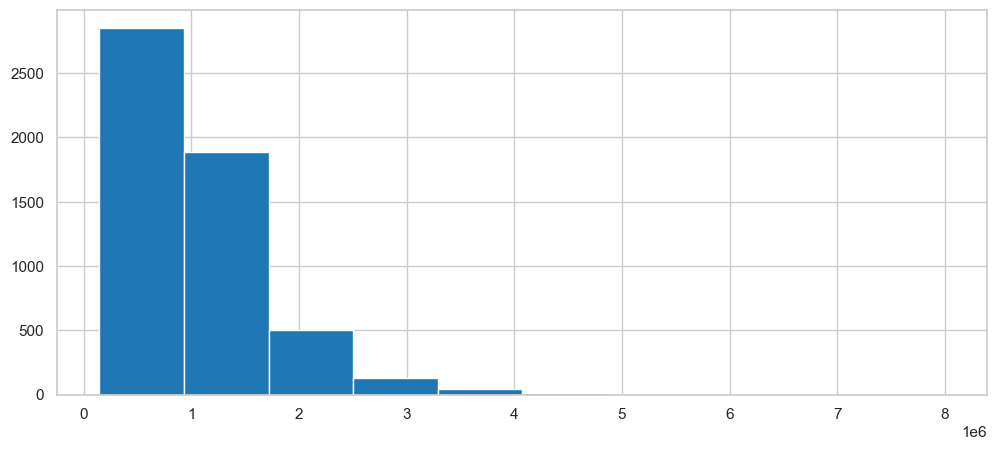

In [318]:
train_set.Price.hist()

In [319]:
train_set['price_range'] = pd.cut(train_set.Price, bins=[.0, .5e6, 1e6, 1.5e6, 2e6, 10e6], labels=[1, 2, 3, 4, 5])

<AxesSubplot:>

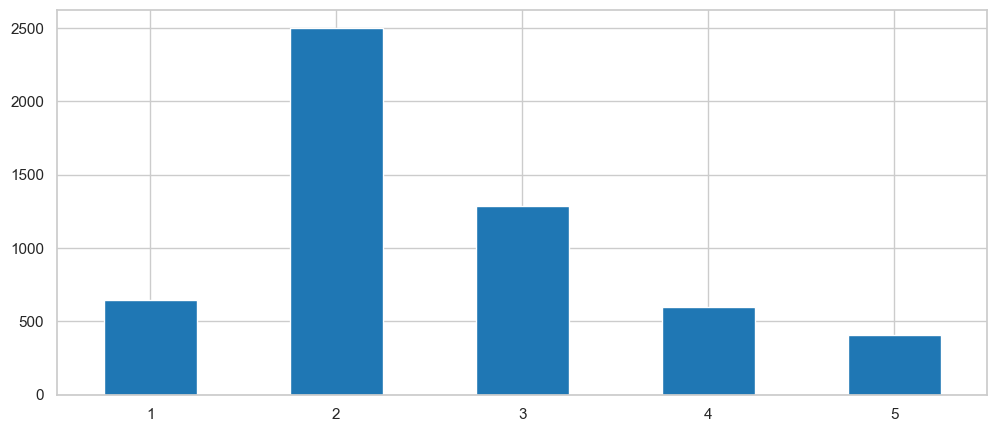

In [320]:
train_set.price_range.value_counts().sort_index().plot.bar(rot=0, grid=True)

In [321]:
train_set_labels = train_set.drop(['price_range'], axis=1, inplace=False)
train_set_target = train_set.price_range

X_train, X_val, Y_train, Y_val = train_test_split(
    train_set_labels, 
    train_set_target, 
    stratify=train_set_target, 
    test_size=.1,
    random_state=0
)

In [322]:
train_set = pd.concat([X_train, Y_train], axis=1).drop(['price_range'], axis=1)
valid_set = pd.concat([X_val, Y_val], axis=1).drop(['price_range'], axis=1)

In [323]:
train_set_extended = train_set.copy()
valid_set_extended = valid_set.copy()
test_set_extended = test_set.copy()

In [151]:
print('Size of train set: ', train_set.shape[0])
print('Size of validation set: ', valid_set.shape[0])
print('Size of test set: ', test_set.shape[0])

Size of train set:  4888
Size of validation set:  544
Size of test set:  8148


In [52]:
train_set.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
index,,,,,,,,,,,,,,,,,,,,,
3320,Bundoora,50 Cameron Pde,3,h,687000.0,S,Ray,17/06/2017,12.1,3083.0,3.0,1.0,3.0,559.0,NaN,NaN,Banyule,-37.69849,145.06705,Northern Metropolitan,10175.0
1185,Kensington,25 Rogan La,2,t,700000.0,S,Village,19/11/2016,4.2,3031.0,2.0,1.0,3.0,62.0,NaN,1997.0,Melbourne,-37.79170,144.92310,Northern Metropolitan,5263.0
5059,Essendon,27 Miller St,3,h,1320000.0,S,Rendina,3/06/2017,7.5,3040.0,3.0,2.0,1.0,276.0,149.0,1910.0,Moonee Valley,-37.75126,144.89558,Western Metropolitan,9264.0


## Data Exploration

In [53]:
def diplay_unique_values(df: pd.DataFrame):
    for column in train_set.columns.values:
        print(f'{column.capitalize()} - {train_set[column].dtype} - ', train_set[column].nunique())
    
diplay_unique_values(train_set)

Suburb - object -  290
Address - object -  4861
Rooms - int64 -  8
Type - object -  3
Price - float64 -  1364
Method - object -  5
Sellerg - object -  195
Date - object -  58
Distance - float64 -  192
Postcode - float64 -  185
Bedroom2 - float64 -  11
Bathroom - float64 -  9
Car - float64 -  10
Landsize - float64 -  1099
Buildingarea - float64 -  421
Yearbuilt - float64 -  115
Councilarea - object -  32
Lattitude - float64 -  3299
Longtitude - float64 -  3513
Regionname - object -  8
Propertycount - float64 -  287


In [54]:
train_set.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,4888.000000,4.888000e+03,4888.000000,4888.000000,4888.000000,4888.000000,4866.000000,4888.000000,2587.000000,2962.000000,4888.000000,4888.000000,4888.000000
mean,2.938421,1.077072e+06,10.248159,3106.002455,2.918576,1.534984,1.629470,534.433715,166.065247,1965.187036,-37.810062,144.994992,7398.589812
std,0.952790,6.424295e+05,6.022727,94.718199,0.991636,0.702245,0.988207,1573.360422,890.695946,36.224880,0.079412,0.107535,4350.388614
min,1.000000,1.450000e+05,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1830.000000,-38.174880,144.542370,389.000000
25%,2.000000,6.500000e+05,6.200000,3044.000000,2.000000,1.000000,1.000000,184.000000,92.000000,1940.000000,-37.856865,144.928408,4242.000000
50%,3.000000,9.000000e+05,9.200000,3084.000000,3.000000,1.000000,2.000000,450.000000,125.000000,1970.000000,-37.803500,144.999670,6543.000000
75%,3.000000,1.330250e+06,13.000000,3148.000000,3.000000,2.000000,2.000000,655.000000,175.000000,1999.000000,-37.757400,145.059647,10331.000000
max,8.000000,8.000000e+06,48.100000,3977.000000,20.000000,8.000000,10.000000,75100.000000,44515.000000,2018.000000,-37.408530,145.526350,21650.000000


We can see there are no strange negative values.

In [55]:
# We can assess how many nulls we have from each column
nan_cols = train_set.columns[train_set.isna().any()].tolist()

for nan_col in nan_cols:
    print(f'Column {nan_col}:', train_set[nan_col].isna().sum())

Column Car: 22
Column BuildingArea: 2301
Column YearBuilt: 1926
Column CouncilArea: 503


We can now see that we have also a bit of nullity relation between `Propertycount`, `Car`, and then with `CouncilArea`.

### Categorical Variables

In [56]:
# Can take a closer look to the object ones
train_set.select_dtypes(include=['object']).head(3)

,Suburb,Address,Type,Method,SellerG,Date,CouncilArea,Regionname
index,,,,,,,,
3320,Bundoora,50 Cameron Pde,h,S,Ray,17/06/2017,Banyule,Northern Metropolitan
1185,Kensington,25 Rogan La,t,S,Village,19/11/2016,Melbourne,Northern Metropolitan
5059,Essendon,27 Miller St,h,S,Rendina,3/06/2017,Moonee Valley,Western Metropolitan


### Type

<AxesSubplot:xlabel='count', ylabel='Type'>

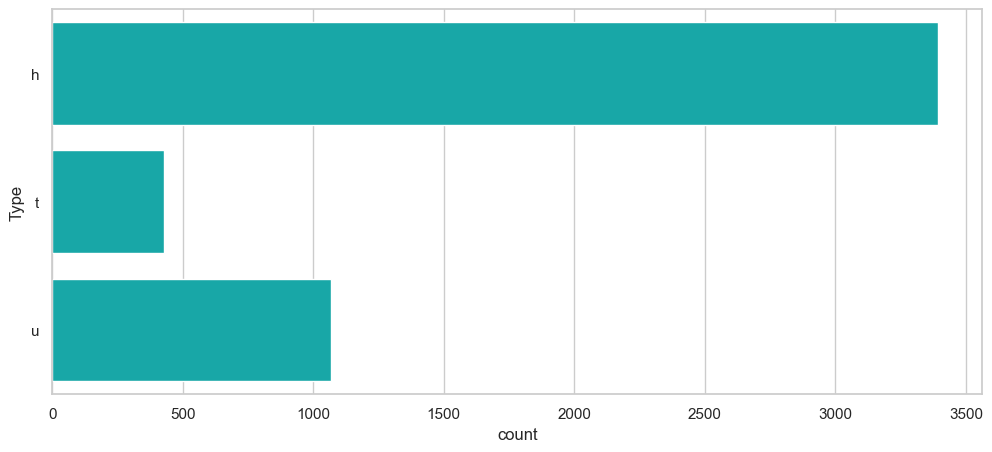

In [57]:
sns.countplot(
    y='Type',
    data=train_set,
    color='c'
)

We have the different types:
- **h**: hourse, cottage, villa, semi, terrace
- **u**: unit, duplex
- **t**: townhouse

And we can see that the majority of them are of type *h*.

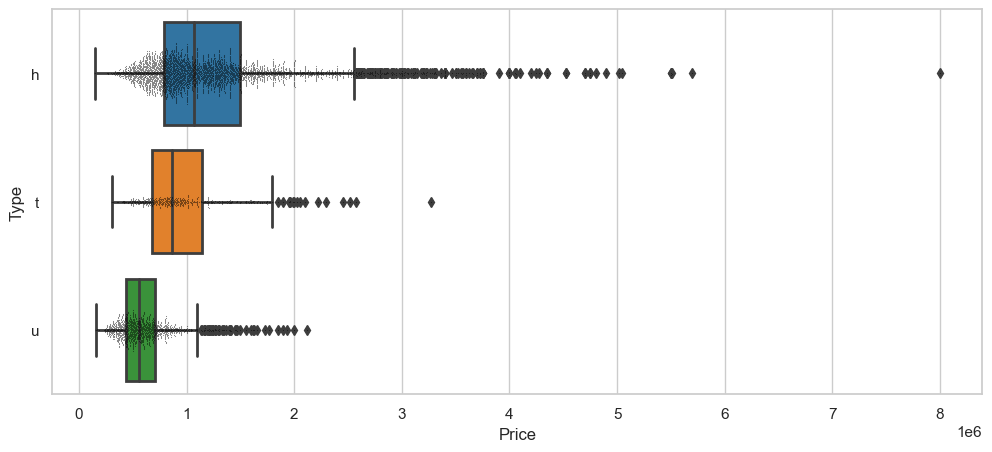

In [58]:
sns.boxplot(
    x='Price',
    y='Type',
    data=train_set,
)

sns.swarmplot(
    x="Price", 
    y="Type", 
    data=train_set, 
    color='black', 
    alpha = 0.5,
    size=0.8
);

We can see important outliers.

Will create a function that removes the outliers grouping by certain categorical variables.

In [59]:
# We will compute the z-score for the prices of houses grouping by the region, and removing outliers (z-score > 3)
def rm_categorical_target_col_outlier(
    df: pd.DataFrame,
    target_col: str = 'Price',
    group_cols: typing.List[str] = ['Type', 'Method', 'Regionname'],
    bound: typing.Tuple[float, float] = (-3., 3.),
    drop_set: bool = set(),
    drop: bool = True
) -> typing.List[int]:
    
    all_dropped = []
    
    for group_col in group_cols:
        for group in df[group_col].unique():
            df_subset = df.loc[df[group_col] == group, target_col].to_frame()
            subset_z_score = df_subset.apply(zscore)

            # And now we drop those indices of the rows that have z-score out of bounds (-3, 3)
            to_drop = list(
                (subset_z_score[(subset_z_score > bound[1]).values].index)) + list(
                (subset_z_score[(subset_z_score < bound[0]).values].index)
            )
            all_dropped += to_drop

    # So we do not interfere in detecting other outliers
    all_dropped = set(all_dropped)
    all_dropped = all_dropped | drop_set
    
    if drop:
        df.drop(
            all_dropped, 
            axis=0, 
            inplace=True
        )
    
    return df, all_dropped

In [60]:
_, drop_set = rm_categorical_target_col_outlier(
    train_set, 
    drop=False
)

_, drop_set = rm_categorical_target_col_outlier(
    train_set, 
    target_col='Landsize', 
    bound=(-3, 2.5),
    drop_set=drop_set, 
    drop=False
)

train_set, _ = rm_categorical_target_col_outlier(
    train_set, 
    target_col='BuildingArea', 
    bound=(-3, 2.5),
    drop_set=drop_set
)

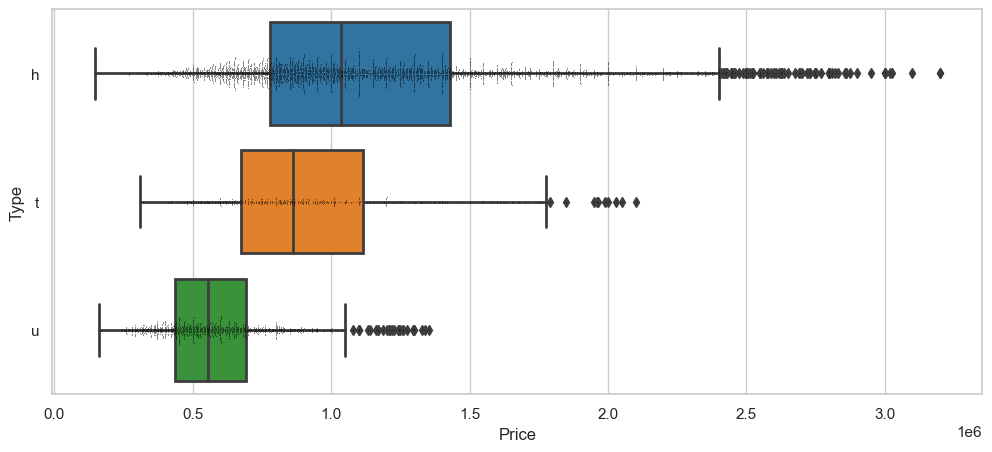

In [61]:
# And can compare with the before plot
sns.boxplot(
    x='Price',
    y='Type',
    data=train_set,
)

sns.swarmplot(
    x="Price", 
    y="Type", 
    data=train_set, 
    color='black', 
    alpha = 0.5,
    size=0.8
);

We can make a qqplot to see if there is normality of the pricess grouping by this categorical variable.

In [62]:
def qqplot_price_category(
    df: pd.DataFrame, 
    category_group: str,
    target_col: typing.Optional[str] = 'Price',
    input_shape: typing.Optional[typing.List[int]] = [1, 3],
    delete_last: typing.Optional[bool] = False
):
    # Consider normality of price distribution in each group to apply ANOVA 
    fig, axs = plt.subplots(input_shape[0], input_shape[1], figsize=(16, 14))

    x_row, y_col = 0, -1
    for idx, value in enumerate(df[category_group].unique()):
        x_row = x_row + 1 if idx % 3 == 0 and idx > 0 else x_row
        y_col = y_col - 2 if idx % 3 == 0 and idx > 0 else y_col + 1
        
        region_set = df.loc[df[category_group].eq(value), target_col]
        
        ax = axs[x_row, y_col] if input_shape[0] > 1 else axs[idx]

        pg.qqplot(
            region_set, 
            dist='norm', 
            ax=ax
        )
        ax.set_title(value)

    plt.tight_layout()
    
    if delete_last:
        fig.delaxes(axs[input_shape[0] - 1][input_shape[1] - 1])

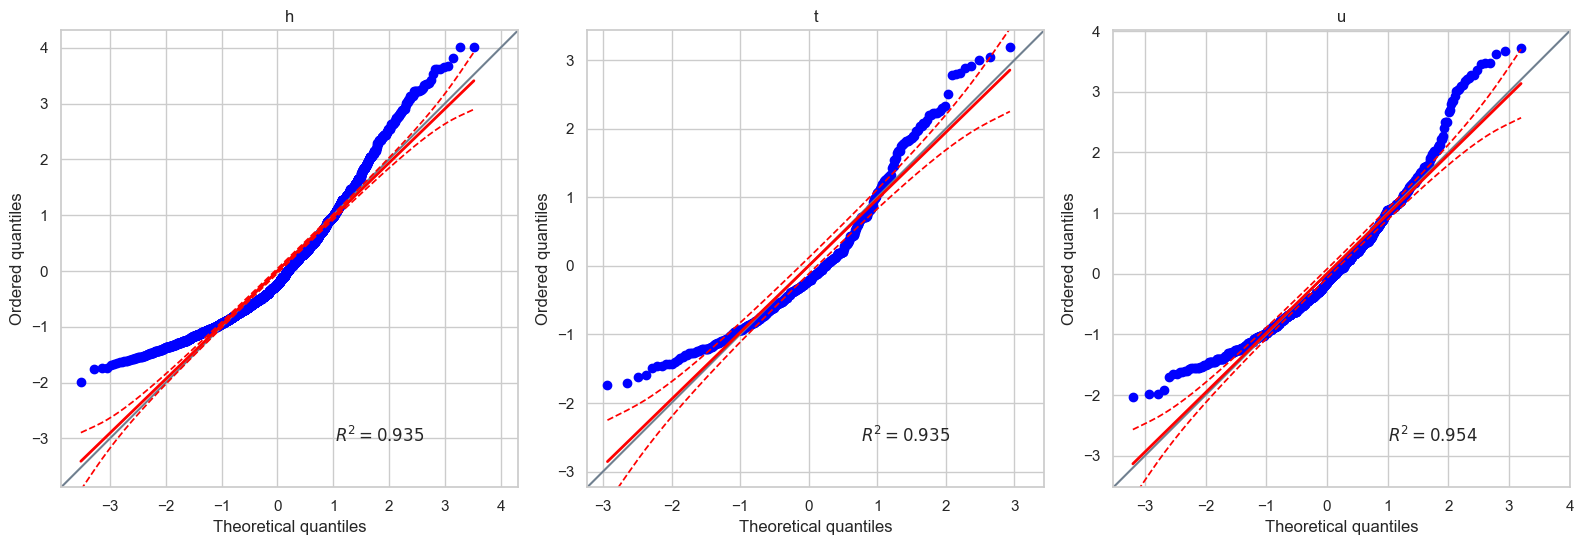

In [63]:
qqplot_price_category(
    train_set,
    category_group='Type'
)

In [64]:
# We can make Levene homoscedasticity test
pg.homoscedasticity(
    data=train_set, 
    dv='Price', 
    group='Type', 
    method='levene'
)

,W,pval,equal_var
levene,242.370964,7.192351e-101,False


### Region Name

Visualize a boxplot with the outliers also removed for this categorical variable.

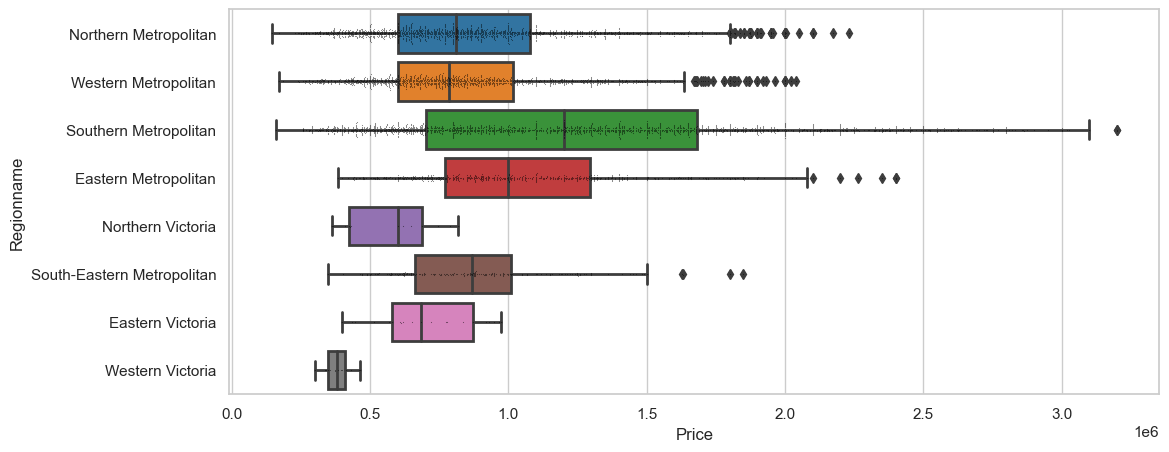

In [65]:
sns.boxplot(
    x='Price',
    y='Regionname',
    data=train_set,
)

sns.swarmplot(
    x="Price", 
    y="Regionname", 
    data=train_set, 
    color='black', 
    alpha = 0.5,
    size=0.8
);

We can still see that there is a difference in the visualization on the distribution.

We might have to do a test to know if this difference of distributions is important to take into consideration. For this, we could make an ANOVA test.

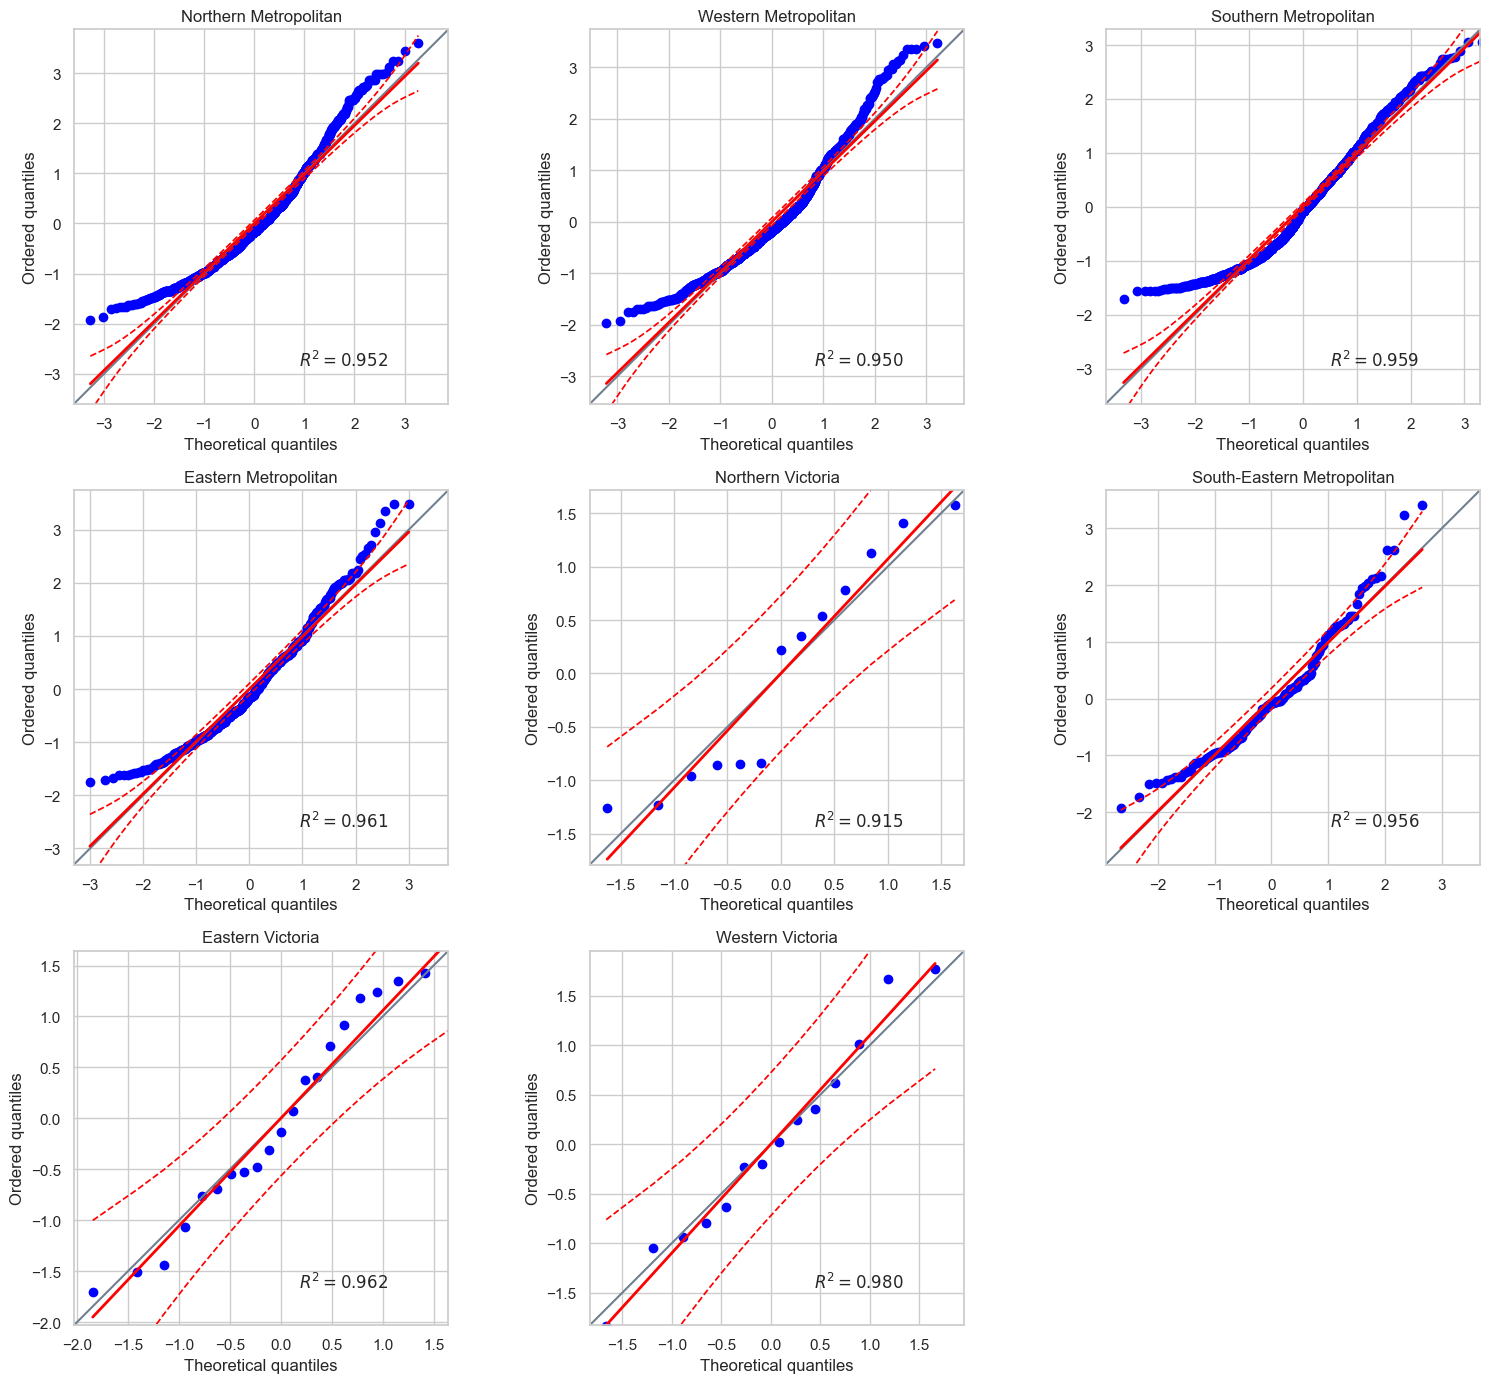

In [66]:
qqplot_price_category(
    train_set,
    category_group = 'Regionname',
    input_shape = [3, 3],
    delete_last=True
)

In [67]:
# We can also make the test Shapiro-Wilk to assess the normality
pg.normality(
    data=train_set, 
    dv='Price', 
    group='Regionname'
)

,W,pval,normal
Regionname,,,
Northern Metropolitan,0.951057,1.635049e-20,False
Western Metropolitan,0.949255,1.191204e-18,False
Southern Metropolitan,0.958641,1.344435e-20,False
Eastern Metropolitan,0.960411,1.479844e-10,False
Northern Victoria,0.888075,9.182026e-02,True
South-Eastern Metropolitan,0.955730,2.569383e-05,False
Eastern Victoria,0.941450,2.327526e-01,True
Western Victoria,0.974835,9.337593e-01,True


In [68]:
# We can make Levene homoscedasticity test
pg.homoscedasticity(
    data=train_set, 
    dv='Price', 
    group='Regionname', 
    method='levene'
)

,W,pval,equal_var
levene,122.557526,7.673634e-166,False


So we can only say at most that we have **normal distributions** for two of the regions: Eastern & Western Victoria.

We can try to create the logarithm of the price, and try to assess again the normality of the distribution.

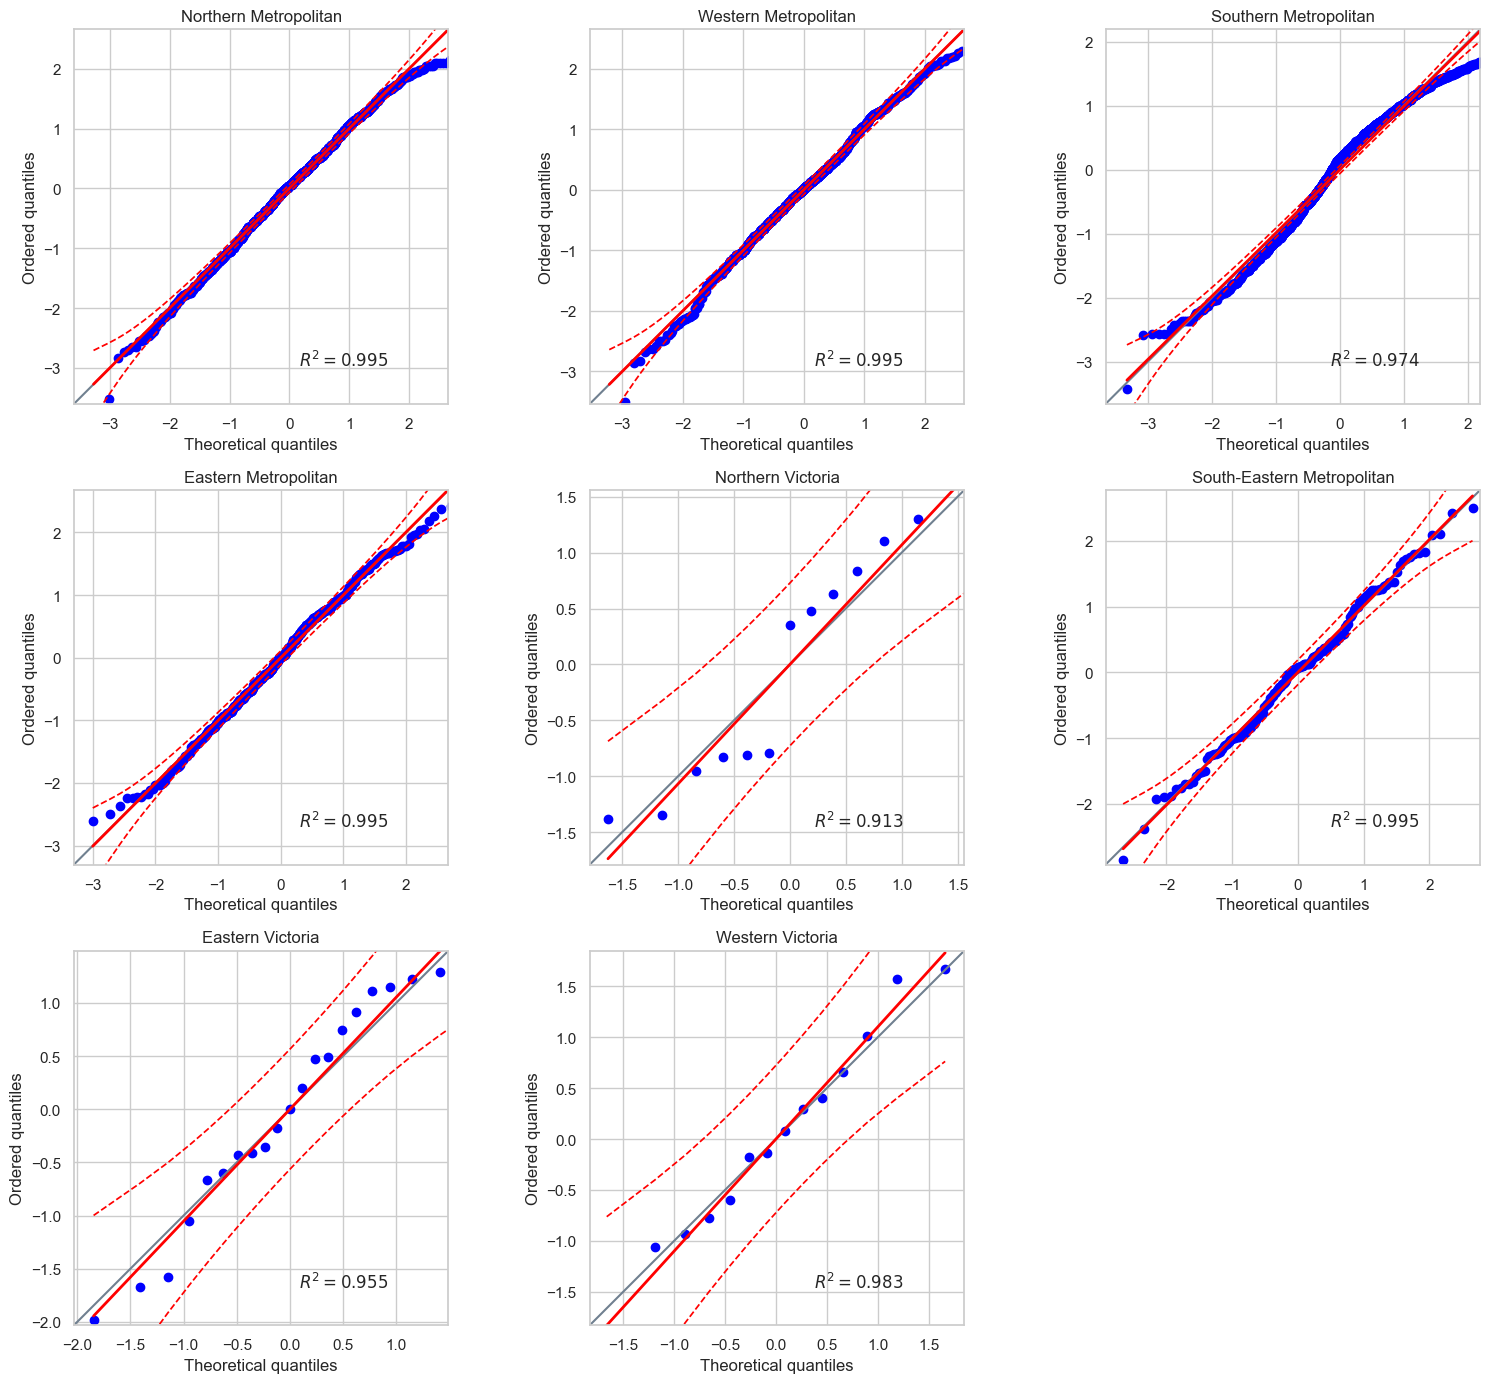

In [69]:
train_set['Price_log'] = np.log(train_set.Price)

qqplot_price_category(
    train_set, 
    target_col='Price_log',
    category_group = 'Regionname',
    input_shape = [3, 3],
    delete_last=True
)

In [70]:
pg.normality(
    data=train_set, 
    dv='Price_log', 
    group='Regionname'
)

,W,pval,normal
Regionname,,,
Northern Metropolitan,0.994590,1.095314e-04,False
Western Metropolitan,0.994749,9.465627e-04,False
Southern Metropolitan,0.973125,1.906473e-16,False
Eastern Metropolitan,0.993864,3.492184e-02,False
Northern Victoria,0.885219,8.394790e-02,True
South-Eastern Metropolitan,0.993931,6.885457e-01,True
Eastern Victoria,0.938173,2.004700e-01,True
Western Victoria,0.979431,9.713764e-01,True


It is now more like a normal distribution of the prices divided by the regions.

So we can make now an ANOVA, to assess which is the influence of the Region Name on the logarithm of the pricing.

In [71]:
pg.anova(
    data=train_set, 
    dv='Price_log', 
    between='Regionname', 
    detailed=True
)

,Source,SS,DF,MS,F,p-unc,np2
0,Regionname,117.798152,7,16.828307,78.021282,2.037610e-107,0.104905
1,Within,1005.109255,4660,0.215689,NaN,NaN,NaN


We have very small **p-value**, which means that we could reject the null hyphotesis that the means of the logarithmic prices across Region Names are the same.

### Method

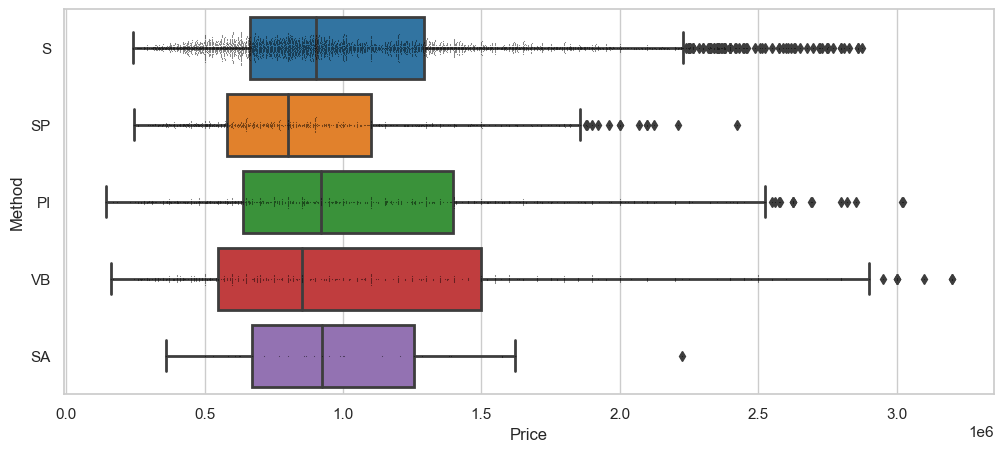

In [72]:
sns.boxplot(
    x='Price',
    y='Method',
    data=train_set,
)

sns.swarmplot(
    x="Price", 
    y="Method", 
    data=train_set, 
    color='black', 
    alpha = 0.5,
    size=0.8
);

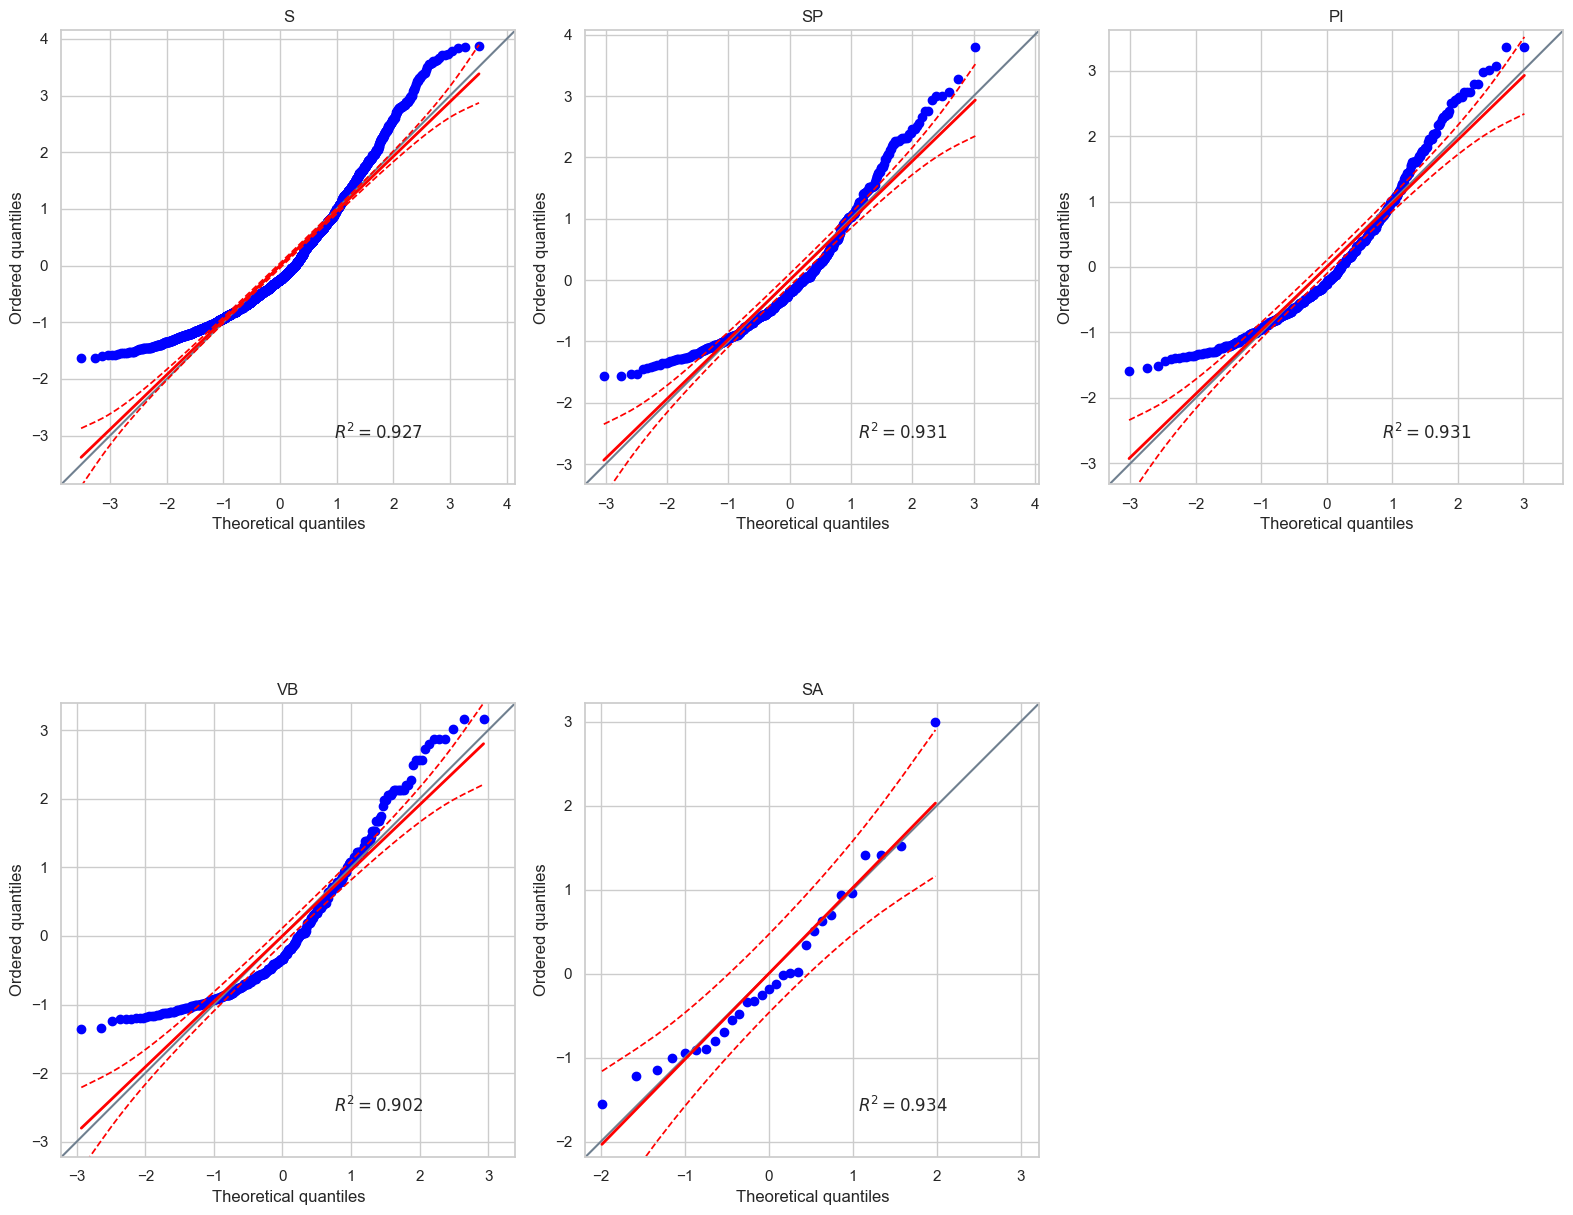

In [73]:
qqplot_price_category(
    train_set,
    category_group = 'Method',
    input_shape = [2, 3],
    delete_last=True
)

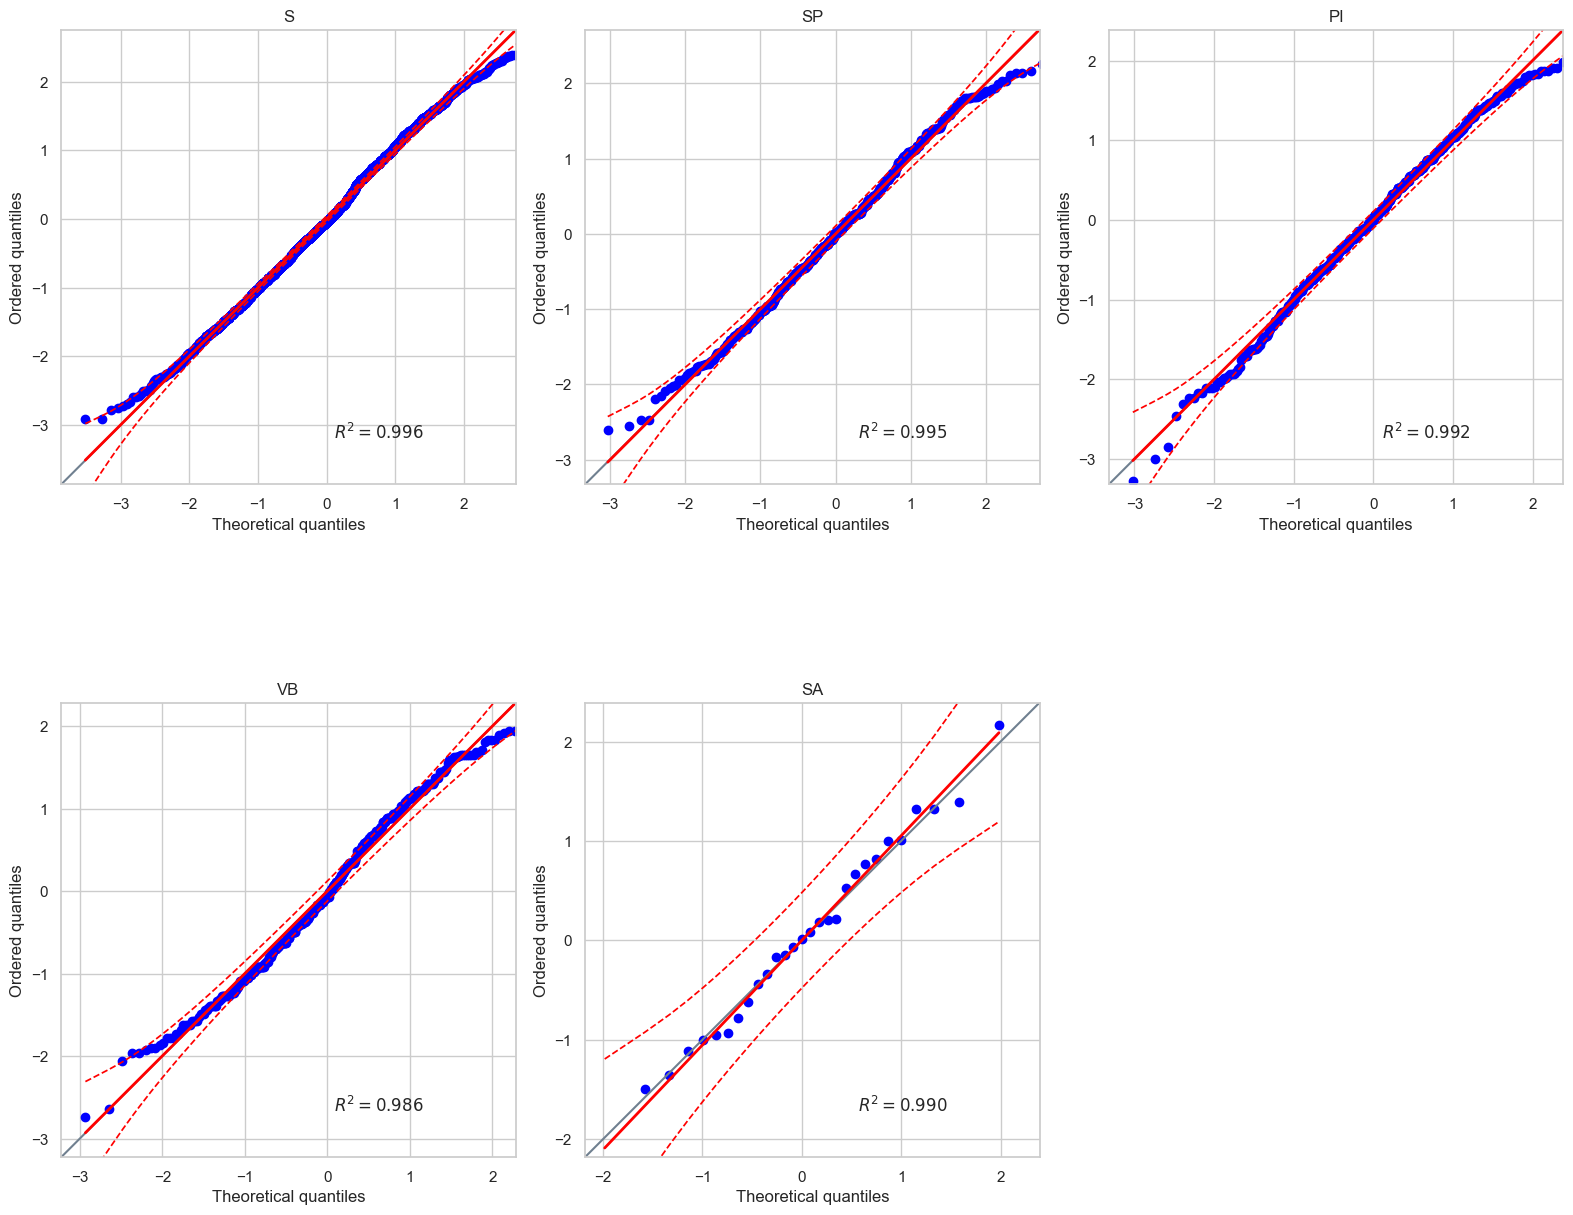

In [74]:
qqplot_price_category(
    train_set,
    target_col='Price_log',
    category_group = 'Method',
    input_shape = [2, 3],
    delete_last=True
)

In [75]:
pg.anova(
    data=train_set, 
    dv='Price', 
    between='Method', 
    detailed=True
)

,Source,SS,DF,MS,F,p-unc,np2
0,Method,1.302872e+13,4,3.257181e+12,12.853477,2.083305e-10,0.010906
1,Within,1.181644e+15,4663,2.534086e+11,NaN,NaN,NaN


## SellerG

We could try to divide the seller into normal/expensive/premium ones, depending on which is the mean of the houses that they sell.

/var/folders/p0/12vcby4x6nxfqn51s513m16c0000gn/T/ipykernel_37103/2215098620.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  seller_pricing = train_set\


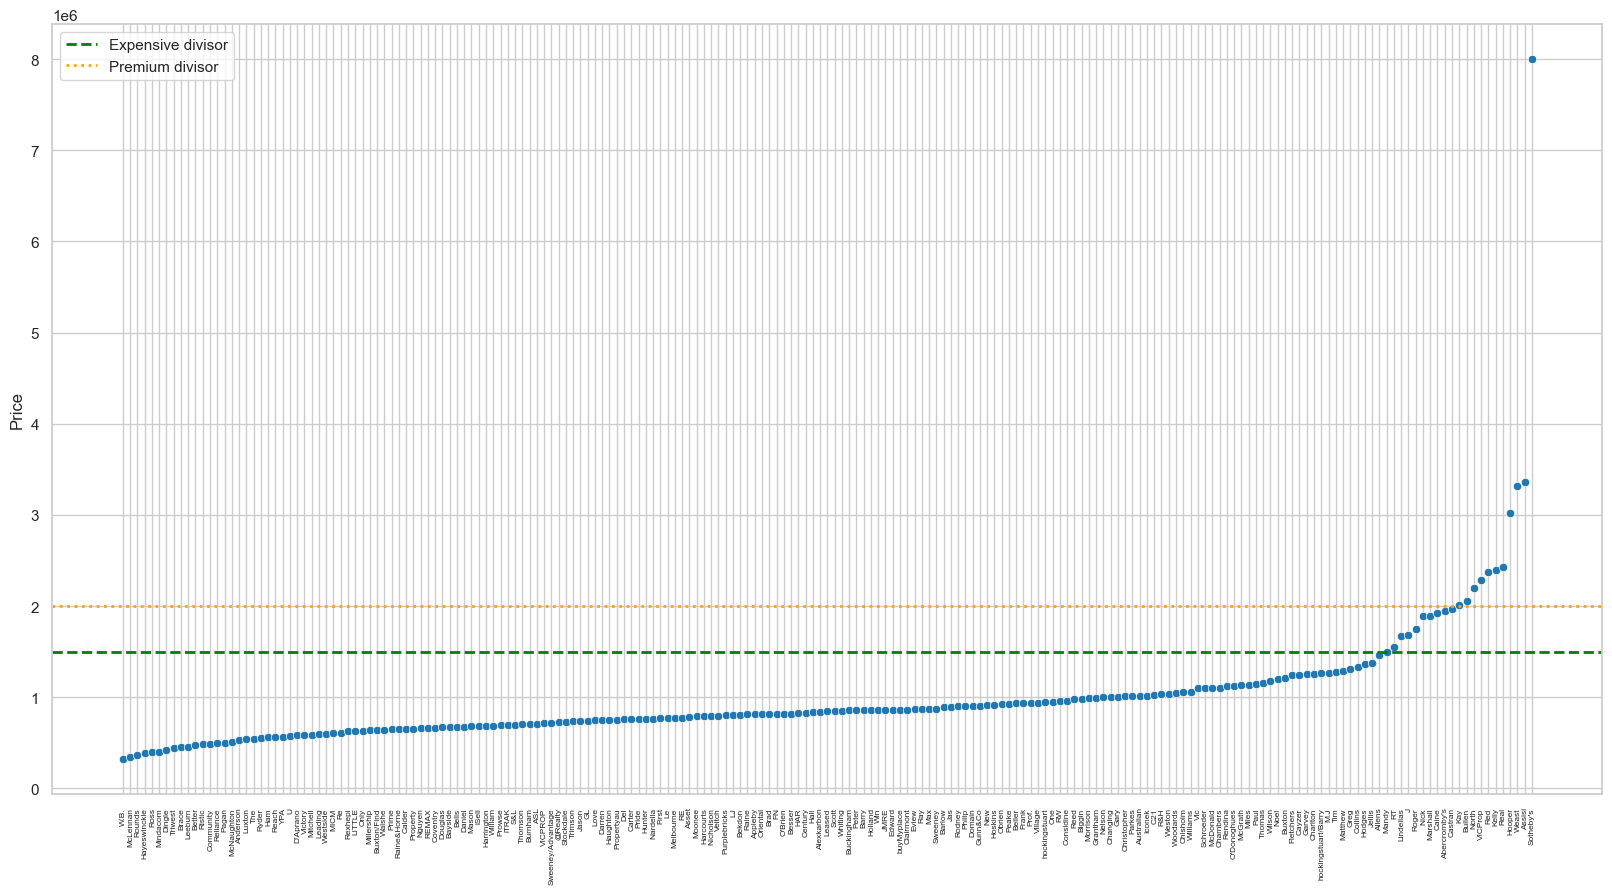

In [324]:
seller_pricing = train_set\
    .groupby('SellerG')\
    .mean()['Price']\
    .sort_values()
    
seller_names = seller_pricing.index.values.tolist()

fig, ax = plt.subplots(figsize=(20, 10))

sns.scatterplot(
    x=seller_names,
    y=seller_pricing,
    ax=ax
)

plt.axhline(
    y=1.5e6, 
    color='green',
    linestyle='--',
    label='Expensive divisor'
)

plt.axhline(
    y=2e6, 
    color='orange',
    linestyle='dotted',
    label='Premium divisor'
)

plt.xticks(
    size=6,
    rotation=90
);

plt.legend()

In [325]:
train_set.loc[
    train_set['SellerG'].isin(list(seller_pricing[seller_pricing >= 2e6].index.values)), 
    'seller_class'
] = 2

train_set.loc[
    train_set['SellerG'].isin(list(seller_pricing[(seller_pricing >= 1.5e6) & (seller_pricing < 2e6)].index.values)), 
    'seller_class'
] = 1

train_set.loc[
    train_set['SellerG'].isin(list(seller_pricing[seller_pricing < 1.5e6].index.values)), 
    'seller_class'
] = 0

In [326]:
premium_sellers = train_set[train_set['seller_class'] == 2.].SellerG.unique()
expensive_sellers = train_set[train_set['seller_class'] == 1.].SellerG.unique()
normal_sellers = train_set[train_set['seller_class'] == 0.].SellerG.unique()

In [327]:
valid_set.loc[
    valid_set['SellerG'].isin(premium_sellers),
    'seller_class'
] = 2

valid_set.loc[
    valid_set['SellerG'].isin(expensive_sellers),
    'seller_class'
] = 1

valid_set.loc[
    valid_set['SellerG'].isin(normal_sellers),
    'seller_class'
] = 0

test_set.loc[
    test_set['SellerG'].isin(premium_sellers),
    'seller_class'
] = 2

test_set.loc[
    test_set['SellerG'].isin(expensive_sellers),
    'seller_class'
] = 1

test_set.loc[
    test_set['SellerG'].isin(normal_sellers),
    'seller_class'
] = 0

In [328]:
# And for the ones in training that are not on testing
valid_set.seller_class.fillna(0, inplace=True)
test_set.seller_class.fillna(0, inplace=True)

In [329]:
seller_features = ['seller_class']

## Numerical Variables

To start with this, we can first compute which is the correlation between the numerical variables.

<AxesSubplot:>

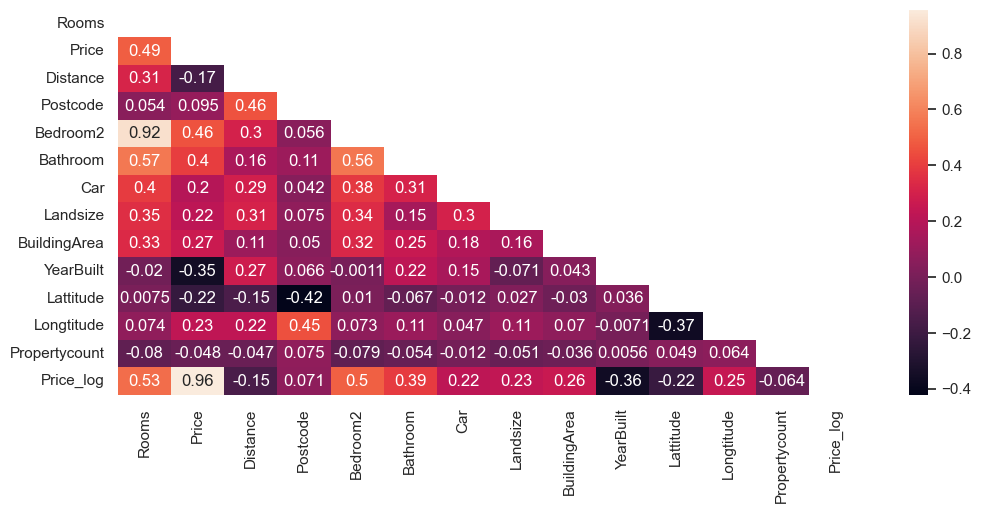

In [81]:
corr = train_set.corr(numeric_only=True)

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

sns.heatmap(
    corr,
    annot=True,
    mask=matrix
)

So we can see that there are some variables with more correlation with price than logarithmic price:
- **Distance**
- **Bedroom2**
- **Bathroom**

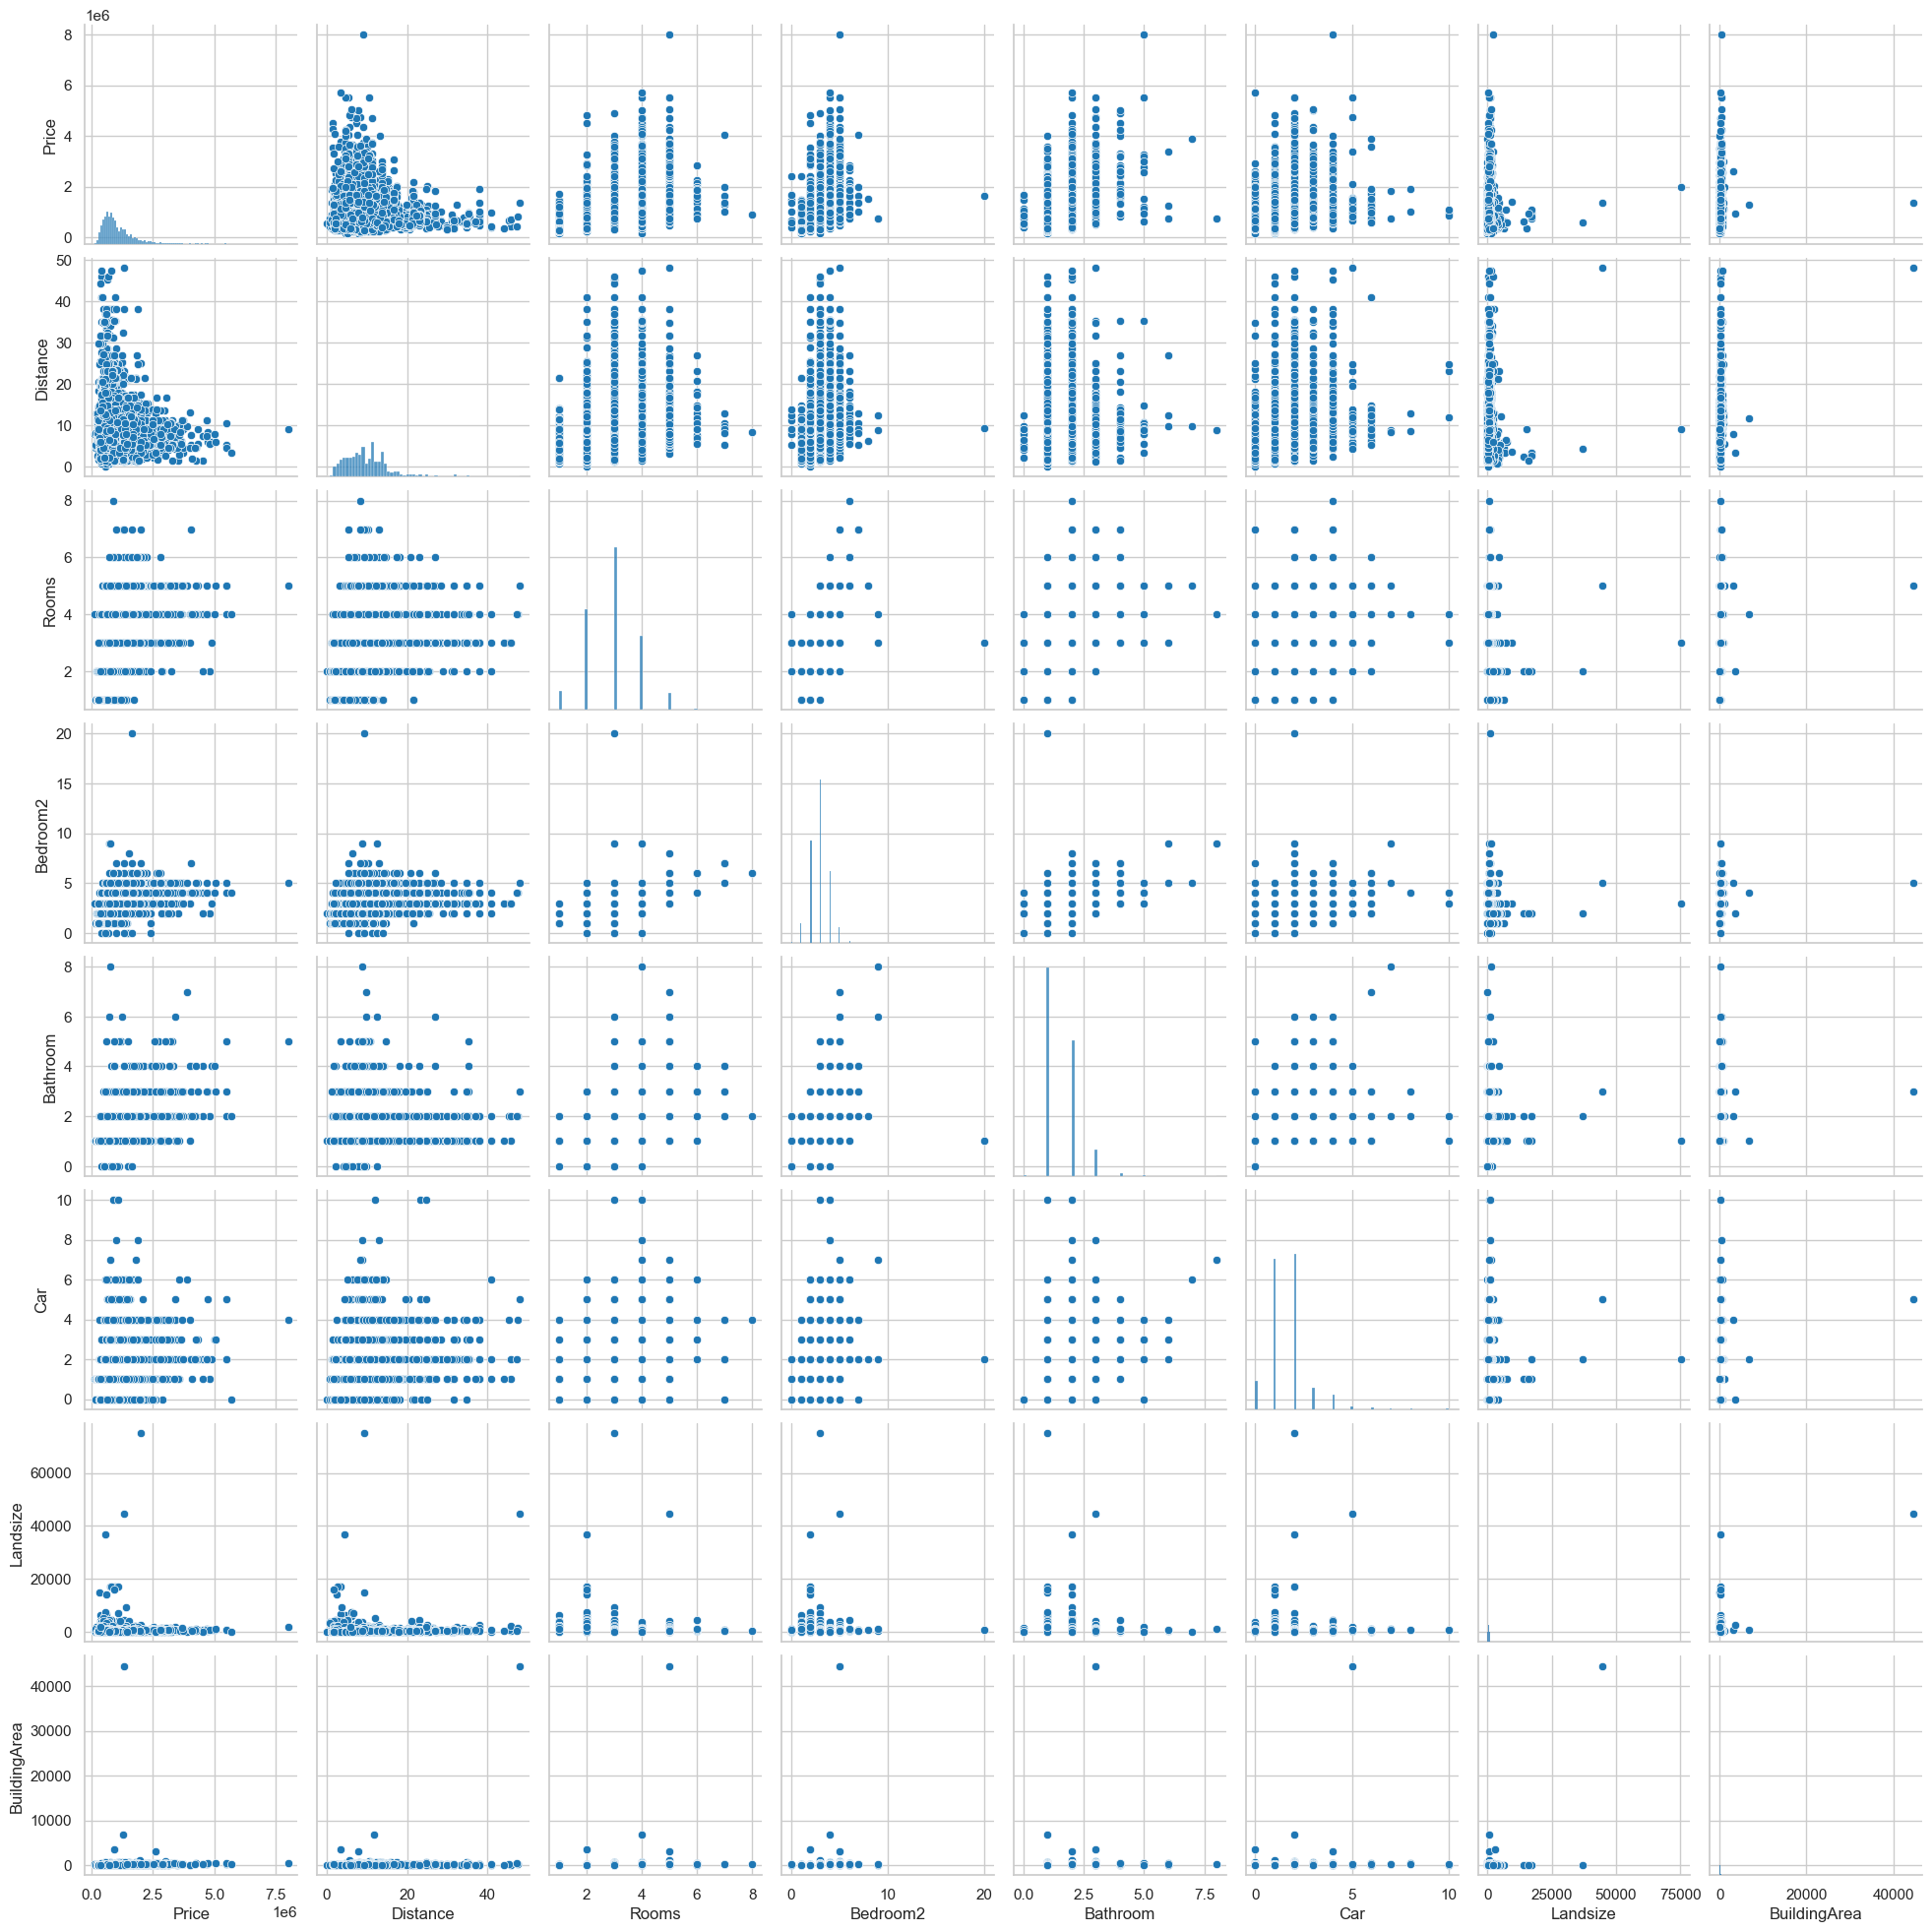

In [157]:
# We can create also pairplot so see how the distribution pairs are
sns.pairplot(
    train_set[['Price', 'Distance', 'Rooms', 'Bedroom2', 'Type', 'Bathroom', 'Car', 'Landsize', 'BuildingArea']]
)

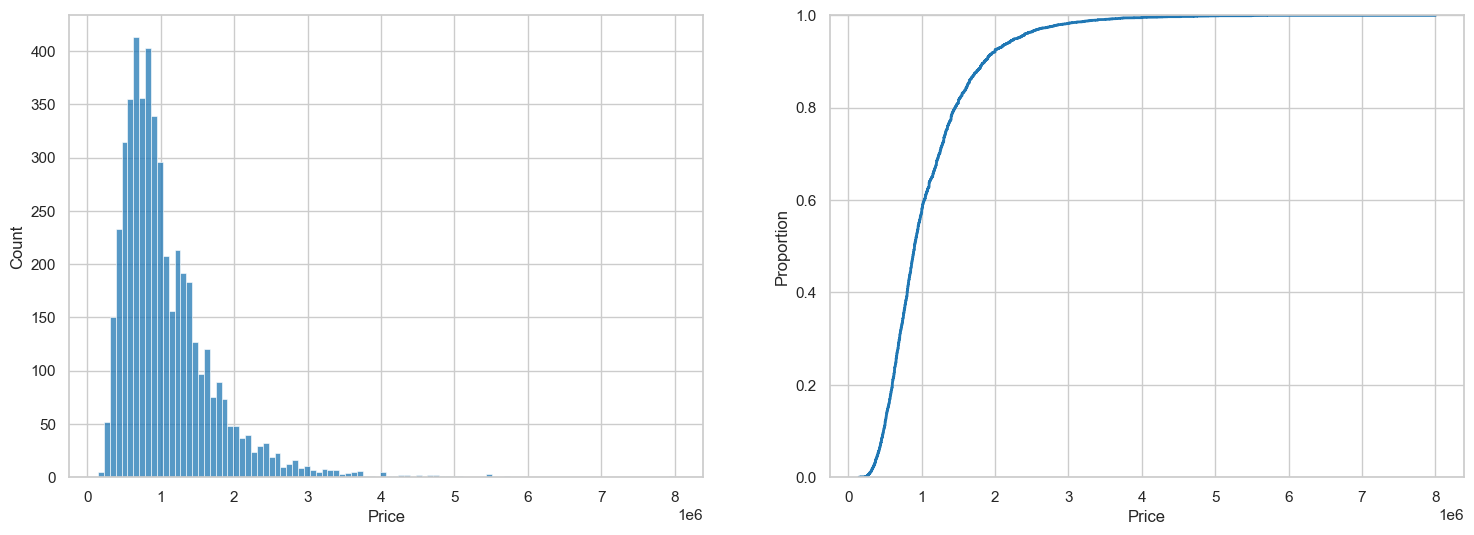

In [158]:
# We can plot more in detail the target variable
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(train_set['Price'], ax=ax1)
sns.ecdfplot(train_set['Price'], ax=ax2)
plt.show()

So we can see that more than 80% of the prices are below 150.000 dollars.

## Landsize & BuildingArea

In [190]:
# Will filter just for the purpose of the plot
train_set_filtered = train_set[train_set.BuildingArea.notna()]
train_set_filtered = train_set_filtered[train_set_filtered.BuildingArea > 0]
train_set_filtered = train_set_filtered[train_set_filtered.Landsize > 0]
train_set_filtered = train_set_filtered[train_set_filtered.Landsize < 10000]


#### TODO: Handle the -: maybe use landsize multiplier relation of something like that 

<AxesSubplot:xlabel='Landsize', ylabel='BuildingArea'>

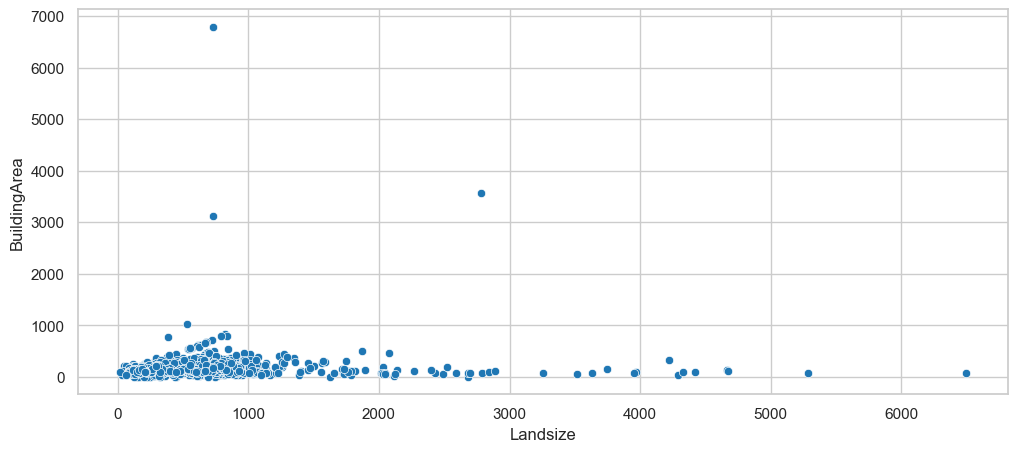

In [191]:
sns.scatterplot(
    x='Landsize',
    y='BuildingArea',
    data=train_set_filtered
)

## Relation property count & price

# Data Processing

## Handling NaN

In [163]:
def fill_target_nan_grouped_column(
    target: str, 
    grouped: str, 
    data: pd.DataFrame,
    statistic: str = 'median'
):

    data[target] = data[target]\
        .fillna(
            data\
                .groupby(grouped)[target]\
                .transform(statistic)
        )

    return data

In [242]:
def drop_column_na(
    data: pd.DataFrame,
    target: str,
):
    # Still some of them keep being NaN, we will drop them    
    return data

## Cars

<AxesSubplot:>

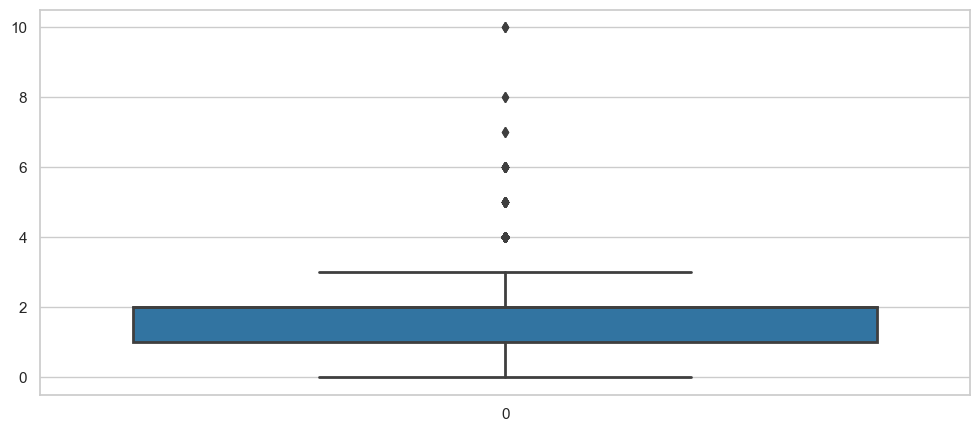

In [165]:
sns.boxplot(
    train_set['Car']
)

In [166]:
train_set_car_na = train_set[train_set['Car'].isna()]
train_set_car_na.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,seller_class
index,,,,,,,,,,,,,,,,,,,,,,
3011,Prahran,19 Porter St,1,u,515000.0,S,Biggin,16/09/2017,4.6,3181.0,1.0,1.0,NaN,284.0,NaN,NaN,NaN,-37.85018,144.99006,Southern Metropolitan,7717.0,0.0
1182,Brunswick,1/208 Albion St,1,u,424000.0,SP,Jellis,26/08/2017,5.2,3056.0,1.0,1.0,NaN,334.0,80.0,2009.0,NaN,-37.76078,144.96168,Northern Metropolitan,11918.0,0.0
998,Richmond,29 Type St,2,h,1200000.0,S,Biggin,16/09/2017,2.4,3121.0,2.0,1.0,NaN,135.0,86.0,1890.0,NaN,-37.82132,145.00973,Northern Metropolitan,14949.0,0.0
899,Albert Park,59 Moubray St,3,h,2100000.0,VB,Cayzer,23/09/2017,3.0,3206.0,3.0,2.0,NaN,137.0,125.0,1890.0,NaN,-37.84388,144.95303,Southern Metropolitan,3280.0,0.0
4482,Armadale,45 Northcote Rd,3,h,1450000.0,VB,hockingstuart,16/09/2017,6.3,3143.0,3.0,1.0,NaN,245.0,NaN,NaN,NaN,-37.85335,145.01698,Southern Metropolitan,4836.0,0.0


<AxesSubplot:xlabel='Price', ylabel='Count'>

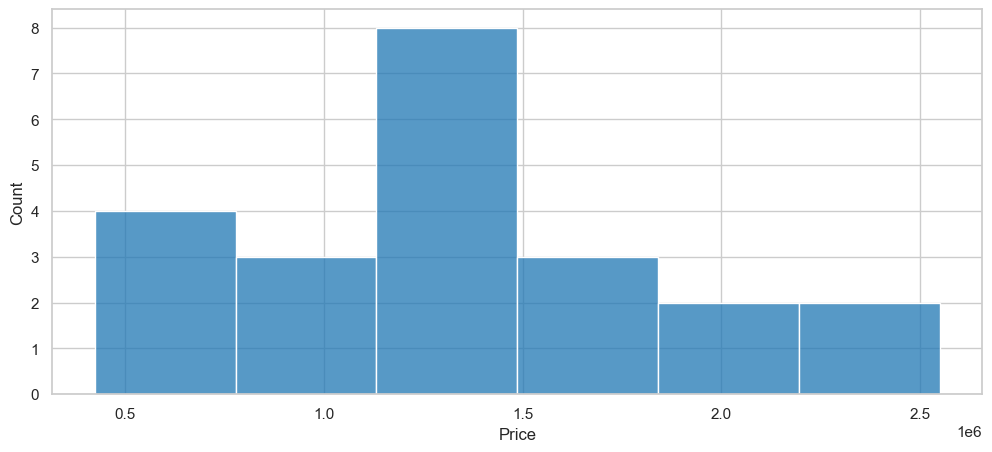

In [167]:
# Look at the price if those are observations of extreme relevance
sns.histplot(train_set_car_na['Price'])

In [330]:
# We can see that nearly half of them are from 19th century
train_set_car_na['YearBuilt'].value_counts()

1900.0    4
1890.0    3
2009.0    1
1910.0    1
1880.0    1
1970.0    1
1930.0    1
1990.0    1
Name: YearBuilt, dtype: int64

In [331]:
# For those, we assume that there where no cars in those houses
train_set.loc[
    (train_set['YearBuilt'] < 1940).index,
    'Car'
] = 0.0  

valid_set.loc[
    (valid_set['YearBuilt'] < 1940).index,
    'Car'
] = 0.0 

test_set.loc[
    (test_set['YearBuilt'] < 1940).index,
    'Car'
] = 0.0 

In [332]:
# For the other ones would place the median
train_set_car_median = train_set['Car'].median()

train_set['Car'].fillna(train_set_car_median, inplace=True)
valid_set['Car'].fillna(train_set_car_median, inplace=True)
test_set['Car'].fillna(train_set_car_median, inplace=True)

### YearBuilt

For the year built, we could compute the median of the years in which is was built each suburb. 

Assumming the construction was by areas, and each small area is represented by a suburb.

In [171]:
# Before doing so, we might want to see that the values of yearbuilt for each of suburbs are in quite close range
grouper = train_set.groupby("Suburb")['YearBuilt']
q1, q3 = grouper.quantile(0.25), grouper.quantile(0.75)
iqr = q3 - q1

The median interquantile range is:  17.625
The mean interquantile range is:  27.855113636363637


<AxesSubplot:>

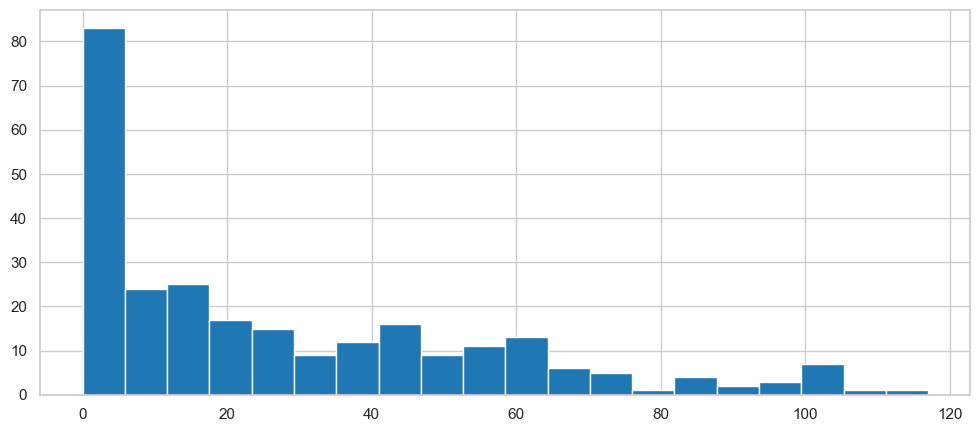

In [172]:
print('The median interquantile range is: ', iqr.median())
print('The mean interquantile range is: ', iqr.mean())

iqr.hist(bins=20)

In [173]:
train_set['SellerG'].nunique()

195

So it does not seem a good solution to replace the NaN with the median or the mean, as it has great variance.

Have tried **KNeighborsClassifier**, but has not worked very well.

In [355]:
train_set['Date'] = pd.to_datetime(train_set['Date'])
valid_set['Date'] = pd.to_datetime(valid_set['Date'])
test_set['Date'] = pd.to_datetime(test_set['Date'])

train_set['year_sold'] = train_set['Date'].dt.year
valid_set['year_sold'] = valid_set['Date'].dt.year
test_set['year_sold'] = test_set['Date'].dt.year

year_built_features = ['Lattitude', 'Longtitude', 'year_sold', 'Distance', 'seller_class']
year_built_target = ['YearBuilt']

year_built_train_base = train_set.dropna(subset=year_built_target, axis=0, inplace=False)

year_built_train_nans_indices = train_set[year_built_target].isnull().values
year_built_train_nans = train_set[year_built_train_nans_indices]

In [356]:
# Explicative variables
year_built_train_base = year_built_train_base[year_built_features + year_built_target]
year_built_train_base_indices = year_built_train_base.index.values

year_built_train_nans = year_built_train_nans[year_built_features]

# Target variables
Y_year_built_train_base = year_built_train_base[year_built_target].values.ravel()
year_built_train_base.drop(year_built_target, axis=1, inplace=True)

In [357]:
# Create the model in the training data
year_built_model = DecisionTreeClassifier(
    random_state=0,
)

year_built_model.fit(
    year_built_train_base,
    Y_year_built_train_base,
)

DecisionTreeClassifier(random_state=0)

In [361]:
year_built_nans_pred = year_built_model.predict(year_built_train_nans)

In [367]:
train_set.loc[
    year_built_train_nans_indices.ravel(),
    'YearBuilt'
] = year_built_nans_pred

In [300]:
# We will use this classifier to infer the NaNs that we have in train, valid and test
year_built_valid_base = valid_set.dropna(subset=year_built_target, axis=0, inplace=False)
year_built_valid_nans = valid_set[valid_set[year_built_target].isna()]

# Explicative variables
year_built_valid_base = year_built_valid_base[year_built_features + year_built_target]
year_built_valid_base_indices = year_built_valid_base.index.values
year_built_valid_nans = year_built_valid_nans[year_built_features]

# Target variables
Y_year_built_valid_base = year_built_valid_base[year_built_target].values.ravel()
year_built_valid_base.drop(year_built_target, axis=1, inplace=True)

In [302]:
# Can assess the model accuracy on staging
year_built_valid_pred = year_built_model.predict(year_built_valid_base)
accuracy_score(Y_year_built_valid_base, year_built_valid_pred)

0.09411764705882353

#### TODO: Apply this model trained on train set (both for training and inferring NaNs in train, val & test)

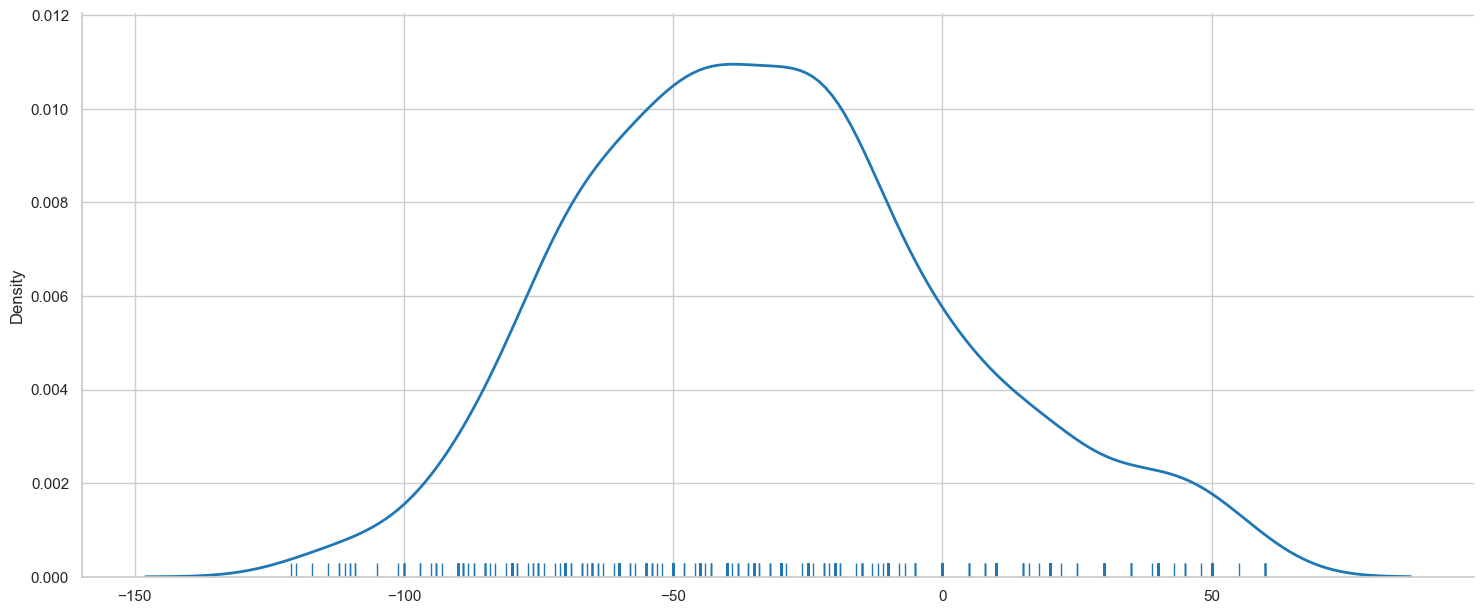

In [59]:
errors = []
for idx in range(len(year_sold_pred)):
    error = int((Y_train_base_set_year_sold[idx] - year_sold_pred[idx])[0])
    errors.append(error)

ax = sns.displot(
    errors,
    kind='kde',
    height=6.27, 
    aspect=15/6.27
);
sns.rugplot(
    errors,
);

### BuildingArea

We can build a regression model for predicting which is the Building Area.

We can infer some outliers for both the Landsize and Building Area.

This is why we are going to use the **Ridge Regression**, to do not make the outliers harm a lot our prediction.

#### TODO: Apply regression robust to outliers

In [62]:
train_set_filtered = train_set_filtered[train_set_filtered['Car'].notna()]
train_set_filtered.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Price_log
index,,,,,,,,,,,,,,,,,,,,,,
4823,South Melbourne,352 Moray St,4,h,2260000.0,PI,Marshall,7/05/2016,2.1,3205.0,5.0,3.0,0.0,190.0,232.0,1856.0,Port Phillip,-37.83770,144.96530,Southern Metropolitan,5943.0,14.630875
3285,South Melbourne,315 Moray St,4,h,2180000.0,S,Marshall,10/12/2016,2.1,3205.0,4.0,3.0,1.0,200.0,153.0,1860.0,Port Phillip,-37.83600,144.96500,Southern Metropolitan,5943.0,14.594835
4757,Albert Park,59 Barrett St,3,h,2340000.0,S,Greg,26/08/2017,3.0,3206.0,3.0,2.0,1.0,162.0,135.0,1880.0,NaN,-37.84398,144.95044,Southern Metropolitan,3280.0,14.665661


In [63]:
# Can apply grid search for hyperparameter tuning
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)

ridge_model = Ridge()

space = {
    'alpha': np.arange(0, 1.0, 0.01)
}

ba_features = ['Landsize', 'Bedroom2', 'Rooms', 'Car']
X_ba_features = train_set_filtered[ba_features]
Y_ba_target = np.array(train_set_filtered['BuildingArea']).reshape(-1, 1)

search = GridSearchCV(
    ridge_model, 
    space, 
    scoring='neg_mean_absolute_error', 
    cv=cv
)

scaler = StandardScaler()
X_landsize_scaled = scaler.fit_transform(X_ba_features)

result = search.fit(X_ba_features, Y_ba_target)

In [64]:
result.best_score_

-43.87709067792883

In [65]:
result.best_estimator_

Ridge(alpha=0.99)

In [66]:
ridge_model = Ridge(alpha=.99)

X_landsize_train, X_landsize_test, Y_building_area_train, Y_building_area_test = train_test_split(
    X_ba_features, 
    Y_ba_target, 
    test_size=0.05, 
    random_state=0
)

<AxesSubplot: xlabel='landsize', ylabel='buildingArea'>

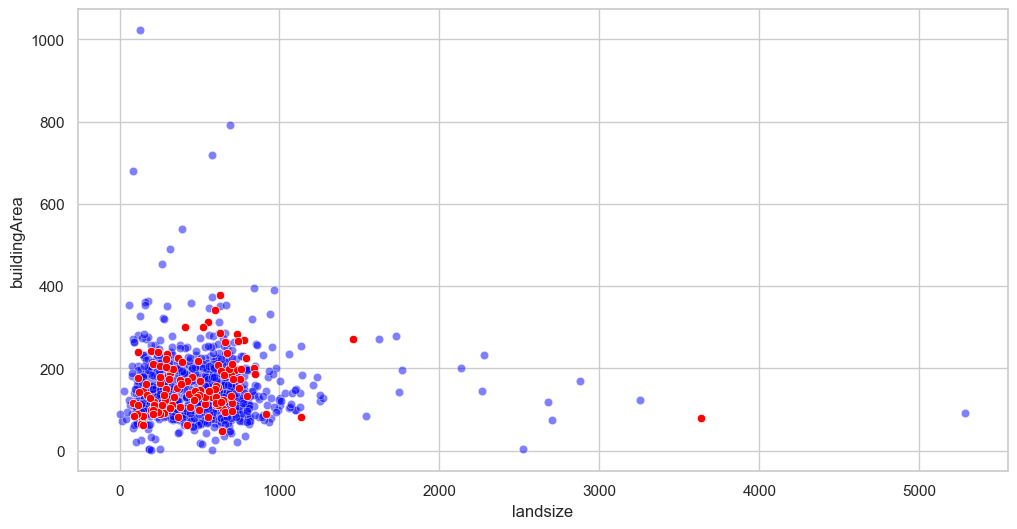

In [67]:
plt.figure(figsize=(12, 6));

train_data_building = pd.concat(
    [
        pd.DataFrame(X_landsize_train['Landsize']), 
        pd.DataFrame(Y_building_area_train)
    ], 
    axis=1)

train_data_building.columns = ['landsize', 'buildingArea']

test_data_building = pd.concat(
    [
        pd.DataFrame(X_landsize_test['Landsize'])\
            .reset_index(drop=True), 
        pd.DataFrame(Y_building_area_test)
    ], 
    axis=1)

test_data_building.columns = ['landsize', 'buildingArea']

ax = sns.scatterplot(
    x='landsize', 
    y='buildingArea',
    data=train_data_building,
    color='b',
    alpha=.5
)

sns.scatterplot(
    x='landsize', 
    y='buildingArea',
    data=test_data_building,
    color='r',
    alpha=1,
    ax=ax
)

In [68]:
ridge_model.fit(X_landsize_train, Y_building_area_train)

pred = ridge_model.predict(X_landsize_test)
mean_squared_error(pred, Y_building_area_test, squared=False)

48.72218707298755

In [69]:
train_set.BuildingArea.mean()

143.4021426241392

So we are having an error of +/- 30% of the **mean**.

(0.0, 350.0)

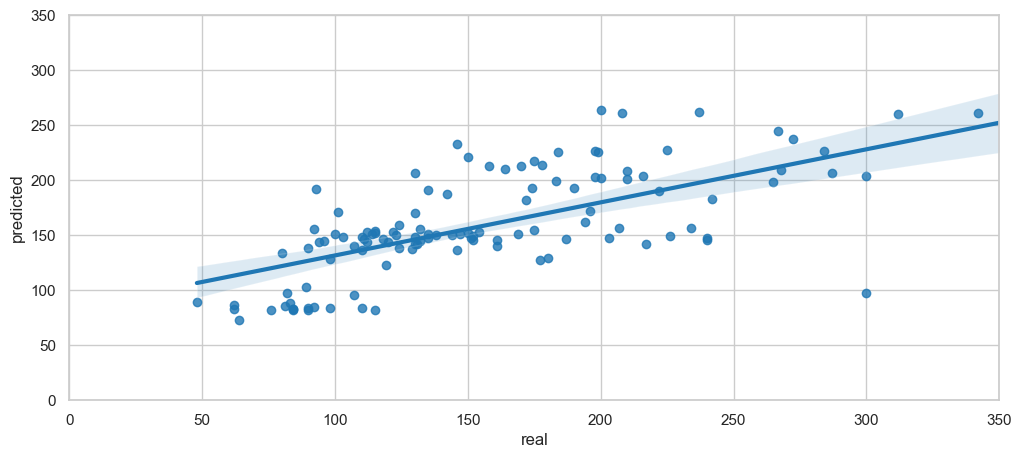

In [70]:
comparison_df = pd.concat(
    [
        pd.DataFrame(Y_building_area_test), 
        pd.DataFrame(pred)
    ], 
    axis=1)

comparison_df.columns = ['real', 'predicted']

sns.regplot(
    x='real', 
    y='predicted',
    data=comparison_df,
)

plt.xlim(0, 350)
plt.ylim(0, 350)

We can try also using the **Lasso** regression:

In [71]:
lasso_model = Lasso()

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)

space = {
    'alpha': np.arange(0.01, 1.0, 0.01)
}

search = GridSearchCV(
    lasso_model, 
    space, 
    scoring='neg_mean_absolute_error', 
    cv=cv
)

scaler = StandardScaler()
X_ba_features_scaled = scaler.fit_transform(X_ba_features)

result = search.fit(X_ba_features_scaled, Y_ba_target)

In [72]:
result.best_score_

-43.68801893937208

In [73]:
result.best_estimator_

Lasso(alpha=0.99)

In [74]:
lasso_model = Lasso(alpha=.99)
lasso_model.fit(X_landsize_train, Y_building_area_train)

pred_lasso = lasso_model.predict(X_landsize_test)
mean_squared_error(pred, Y_building_area_test, squared=False)

48.72218707298755

Approximately we are getting the same error. We will move forward with the Ridge model, which is more robust to overfitting.

So we will now infer the values for the **train_set**:

In [75]:
# And now we would replace the NaN values of the train_set
ba_to_infer = train_set.loc[set(train_set.index) - set(train_set_filtered.index)]
print(ba_to_infer[ba_features].isna().sum(axis=0))
ba_infer_index = ba_to_infer.index

ba_to_infer = scaler.transform(ba_to_infer[ba_features])

Landsize    0
Bedroom2    0
Rooms       0
Car         0
dtype: int64


/tmp/ipykernel_2354179/2408564494.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  ba_to_infer = train_set.loc[set(train_set.index) - set(train_set_filtered.index)]


In [76]:
ba_nan_inferenced = ridge_model.predict(ba_to_infer)

In [77]:
train_set.loc[ba_infer_index, 'BuildingArea'] = ba_nan_inferenced

As well as infer the ones for the **test_set**:

In [78]:
sum(test_set.BuildingArea.isna())

3908

In [79]:
test_set_ba_infer = test_set[test_set.BuildingArea.isna()]
test_set_ba_infer = test_set_ba_infer[test_set_ba_infer['Car'].notna()]
test_ba_infer_index = test_set_ba_infer.index

test_set_ba_infer = scaler.transform(test_set_ba_infer[ba_features])

test_set_ba_nan_inferenced = ridge_model.predict(test_set_ba_infer)
test_set.loc[test_ba_infer_index, 'BuildingArea'] = test_set_ba_nan_inferenced

### Council Area

This rea is strictly related to the longtitude and lattitude.

So we will create a **KNN algorithm**, that extract the information that we want from the coordinates.

NOTE: Not doing Validation as want to extract all possible information from the set.

In [80]:
train_set_base = drop_column_na(train_set, 'CouncilArea', log=False)
train_set_target = train_set[train_set['CouncilArea'].isna()]

# Explicative variables
X_train_base_set_council = train_set_base[['Lattitude', 'Longtitude']]
X_train_target_set_council = train_set_target[['Lattitude', 'Longtitude']]
X_train_target_set_council_index = X_train_target_set_council.index

# Target variables
Y_train_base_set_council = train_set_base['CouncilArea'].values.ravel()

In [81]:
scaler = MinMaxScaler()

# TODO: Train/Test split
X_train_base_set_council = scaler.fit_transform(X_train_base_set_council)
X_train_target_set_council = scaler.transform(X_train_target_set_council)

In [82]:
n_council_area = train_set['CouncilArea'].nunique()
knn_council_area = KNeighborsClassifier(n_council_area)

knn_council_area.fit(X_train_base_set_council, Y_train_base_set_council)

KNeighborsClassifier(n_neighbors=32)

In [83]:
knn_council_area.score(X_train_base_set_council, Y_train_base_set_council)
# TODO: HP tuning to try improve this classification
# TODO: Train/Val split?

0.9321597252039502

In [84]:
# And now we predict for the test set, which is the one with NaN
council_pred = knn_council_area.predict(X_train_target_set_council)

In [85]:
# And finally we replace the council area of the train set
train_set.loc[X_train_target_set_council_index, 'CouncilArea'] = council_pred

In [86]:
# Assert there are no more NaN in train set
train_set['CouncilArea'].isna().sum()

0

**NOTE**: In test_set, we would need to use same classifier for the Council Area.

In [87]:
sum(test_set['CouncilArea'].isna())

816

In [88]:
# Get which is the data needed to make the inference
test_set_target = test_set[test_set['CouncilArea'].isna()][['Lattitude', 'Longtitude']]
test_set_target_trans = scaler.transform(test_set_target)

In [89]:
council_pred = knn_council_area.predict(test_set_target_trans)

In [90]:
# And finally we replace the council area of the train set
test_set.loc[test_set_target.index, 'CouncilArea'] = council_pred

In [91]:
# Check correctly placed
sum(test_set['CouncilArea'].isna())

0

In [92]:
# TODO: Handling YearBuilt
# tODO: Convert to category from object
train_set_formatted = train_set.copy()
test_set_formatted = test_set.copy()
"""date_variables = ['Date']
for col in date_variables:
    train_set[col] = pd.to_datetime(train_set[col])
    test_set[col] = pd.to_datetime(test_set[col])"""

"""categorical_variables = ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname']
for col in categorical_variables:
    train_set[col] = train_set[col].astype('category')
    test_set[col] = test_set[col].astype('category')
    
integer_variables = ['YearBuilt', 'Postcode']
for col in integer_variables:
    train_set[col] = train_set[col].astype('int')
    test_set[col] = test_set[col].astype('int')"""

"categorical_variables = ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname']\nfor col in categorical_variables:\n    train_set[col] = train_set[col].astype('category')\n    test_set[col] = test_set[col].astype('category')\n    \ninteger_variables = ['YearBuilt', 'Postcode']\nfor col in integer_variables:\n    train_set[col] = train_set[col].astype('int')\n    test_set[col] = test_set[col].astype('int')"

# Feature Engineering

Date Feature Enginering:
- Years difference between sold and built
- ratios of beds/rooms, rooms/bathrooms, buildingarea/land, ...
- Use **distance** to DBD (Central Business District: central commercial streets and main public buildings)
- **Seller** names: could group them depending on the size of the houses for example if there is a relation (premium sellers -> would have higher price). Or group sellers in groups of selling houses above mean price/buildingarea_or_land of each of the council-area (so in some council areas we would have some premium sellers, and in others we would have other ones), in range and below that mean for example.
- Create one predicting model for each group of sellers/councils/group areas similarity.

Normalization of features (for LR, in case of Trees not be necessary).

PCA.

## Dates

In [175]:
# Adding information about which is the day, week and year
def temporal_info(data: pd.DataFrame):
    # Convert to datetime
    data['Date'] = pd.to_datetime(data['Date'])
    
    data['year_sold'] = data.Date.dt.year.astype("int32")
    data['month_sold'] = data.Date.dt.month.astype("int8")
    data['quarter_sold'] = data.Date.dt.quarter.astype("int8")
    data['day_of_week_sold'] = (data.Date.dt.dayofweek + 1).astype("int8")
    data['day_of_month_sold'] = data.Date.dt.day.astype("int8")
    data['day_of_year_sold'] = data.Date.dt.dayofyear.astype("int16")
    data['week_of_month_sold'] = (data.Date.apply(lambda d: (d.day-1) // 7 + 1)).astype("int8")
    data['week_of_year_sold'] = (data.Date.dt.weekofyear).astype("int8")
    
    date_features = [
        'year_sold',
        'month_sold',
        'quarter_sold',
        'day_of_week_sold',
        'day_of_month_sold',
        'day_of_year_sold',
        'week_of_month_sold',
        'week_of_year_sold'
    ]
    
    return data, date_features

train_set_extended, date_features = temporal_info(train_set_extended)

/tmp/ipykernel_2354179/661572288.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['week_of_year_sold'] = (data.Date.dt.weekofyear).astype("int8")


In [176]:
# Adding information relative to which is that date
def relevant_dates_info(data: pd.DataFrame):
    data['is_wknd'] = (data.Date.dt.weekday // 4).astype("int8")
    data['is_month_start'] = data.Date.dt.is_month_start.astype("int8")
    data['is_month_end'] = data.Date.dt.is_month_end.astype("int8")
    data['is_quarter_start'] = data.Date.dt.is_quarter_start.astype("int8")
    data['is_quarter_end'] = data.Date.dt.is_quarter_end.astype("int8")
    data['is_year_start'] = data.Date.dt.is_year_start.astype("int8")
    data['is_year_end'] = data.Date.dt.is_year_end.astype("int8")
    
    date_features = [
        'is_wknd',
        'is_month_start',
        'is_month_end',
        'is_quarter_start',
        'is_quarter_end',
        'is_year_start',
        'is_year_end'
    ]
    
    return data, date_features

train_set_extended, new_date_features = relevant_dates_info(train_set_extended)
date_features += new_date_features

In [177]:
def season_info(data: pd.DataFrame):
    data['winter'] = np.where(data.month_sold.isin([12, 1, 2]), 0, 1)
    data['spring'] = np.where(data.month_sold.isin([3, 4, 5]), 0, 1)
    data['summer'] = np.where(data.month_sold.isin([6,7,8]), 0, 1)
    data['fall'] = np.where(data.month_sold.isin([9, 10, 11]), 0, 1)
    
    date_features = [
        'winter', 
        'spring', 
        'summer', 
        'fall'
    ]
    
    return data, date_features

train_set_extended, new_date_features = season_info(train_set_extended)
date_features += new_date_features

In [178]:
train_set_extended['diff_built_sold'] = train_set_extended['year_sold'] - train_set_extended['YearBuilt']
date_features += ['diff_built_sold']

In [98]:
train_set_extended.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Price_log,year_sold,month_sold,quarter_sold,day_of_week_sold,day_of_month_sold,day_of_year_sold,week_of_month_sold,week_of_year_sold,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,winter,spring,summer,fall,diff_built_sold
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4823,South Melbourne,352 Moray St,4,h,2260000.0,PI,Marshall,2016-07-05,2.1,3205.0,5.0,3.0,0.0,190.0,232.000000,1856.0,Port Phillip,-37.8377,144.9653,Southern Metropolitan,5943.0,14.630875,2016,7,3,2,5,187,1,27,0,0,0,0,0,0,0,1,1,0,1,160.0
3285,South Melbourne,315 Moray St,4,h,2180000.0,S,Marshall,2016-10-12,2.1,3205.0,4.0,3.0,1.0,200.0,153.000000,1860.0,Port Phillip,-37.8360,144.9650,Southern Metropolitan,5943.0,14.594835,2016,10,4,3,12,286,2,41,0,0,0,0,0,0,0,1,1,1,0,156.0
68,South Melbourne,52 Eastern Rd,3,h,2525000.0,S,Marshall,2016-11-27,2.1,3205.0,3.0,2.0,1.0,234.0,-50.868776,1863.0,Port Phillip,-37.8355,144.9663,Southern Metropolitan,5943.0,14.741752,2016,11,4,7,27,332,4,47,1,0,0,0,0,0,0,1,1,1,0,153.0


## Address

What we can do with the address is for example to check if there has been any house that is **re-sold**. 

The hyphotesis around it is that re-selling might have an importance in the increment of the price, due to a commercial area.

In [179]:
def add_feature_resold(
    data_duplicated: pd.DataFrame, 
    data_source: pd.DataFrame
):
    
    before, actual = '', ''
    for idx, row in data_duplicated.iterrows():
        if not before:
            before = row['Address']
            data_source.loc[idx, 'Resold'] = 0
            continue

        actual = row['Address']
        if before == actual:
            # Set it directly this new feature on extended dataframe
            data_source.loc[idx, 'Resold'] = 1

        else:
            data_source.loc[idx, 'Resold'] = 0
            before = actual
    
    return data_source

def check_resold_houses(data: pd.DataFrame):
    # Will assume that the ones with same values in address, room, bedroom and bathroom is the same house being sold
    multiple_sold = data[
        data.duplicated(
            subset=['Address', 'Rooms', 'Bedroom2', 'Bathroom'], 
            keep=False
        )
    ].sort_values(['Address', 'Date'])
    
    # And now we add the feature of being sold
    data = add_feature_resold(multiple_sold, data)
    data['Resold'] = data['Resold'].fillna(0).astype('int8')
    
    # An example with the ones sold more than once
    display(data.loc[multiple_sold.index].head(3))
    
    address_feature = ['Resold']
    
    return data, address_feature

train_set_extended, address_feature = check_resold_houses(train_set_extended)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Price_log,year_sold,month_sold,quarter_sold,day_of_week_sold,day_of_month_sold,day_of_year_sold,week_of_month_sold,week_of_year_sold,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,winter,spring,summer,fall,diff_built_sold,Resold
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3470,Glenroy,1/26 York St,3,t,600000.0,VB,Nelson,2016-11-27,13.0,3046.0,3.0,1.0,2.0,258.0,143.000000,2001.0,Moreland,-37.7047,144.9087,Northern Metropolitan,8870.0,13.304685,2016,11,4,7,27,332,4,47,1,0,0,0,0,0,0,1,1,1,0,15.0,0
2564,Glenroy,1/26 York St,3,t,595000.0,SP,Nelson,2017-05-20,13.0,3046.0,3.0,1.0,2.0,258.0,142.600000,2001.0,Moreland,-37.7047,144.9087,Northern Metropolitan,8870.0,13.296317,2017,5,2,6,20,140,3,20,1,0,0,0,0,0,0,1,0,1,1,16.0,1
4957,Sunshine,14 Baker St,4,h,700000.0,PI,Douglas,2016-07-30,12.6,3020.0,4.0,1.0,5.0,650.0,46.769663,1970.0,Brimbank,-37.7867,144.8437,Western Metropolitan,3755.0,13.458836,2016,7,3,6,30,212,5,30,1,0,0,0,0,0,0,1,1,0,1,46.0,0


In [151]:
# Could try to reduce the amount of addresses by removing the number
print('Unique addresses before: ', train_set_extended['Address'].nunique())

train_set_extended['Address'] = train_set_extended['Address'].apply(lambda x: x.split()[1])
train_set_extended['Address']

print('Unique addresses after: ', train_set_extended['Address'].nunique())

Unique addresses before:  5161
Unique addresses after:  2464


In [101]:
# In the case of the Addres, we can see that would not provide a lot of information to have such a categorical variable
train_set_extended.drop(['Address'], axis=1, inplace=True)
test_set_extended.drop(['Address'], axis=1, inplace=True)

## Council Area

Will create the dummy variables for being able to pass this category.

In [180]:
train_set_extended = pd.get_dummies(
    train_set_extended, 
    columns=['CouncilArea'], 
    drop_first=True
)

In [181]:
council_feature_match = re.compile(r'^Council*')
council_features = list(
    filter(council_feature_match.match, train_set_extended.columns.values)
)

## Method

In [182]:
train_set_extended = pd.get_dummies(
    train_set_extended, 
    columns=['Method'], 
    drop_first=True
)

method_feature_match = re.compile(r'^Method*')
method_features = list(
    filter(method_feature_match.match, train_set_extended.columns.values)
)

## Type

In [183]:
train_set_extended = pd.get_dummies(
    train_set_extended, 
    columns=['Type'], 
    drop_first=True
)

type_feature_match = re.compile(r'^Type*')
type_features = list(
    filter(type_feature_match.match, train_set_extended.columns.values)
)

## Longtitude & Lattitude

Instead of using PCA, which would lose the dimension of space, I will assume that there are groups for that location that are of relevent importance for the price.

<AxesSubplot: xlabel='Longtitude', ylabel='Lattitude'>

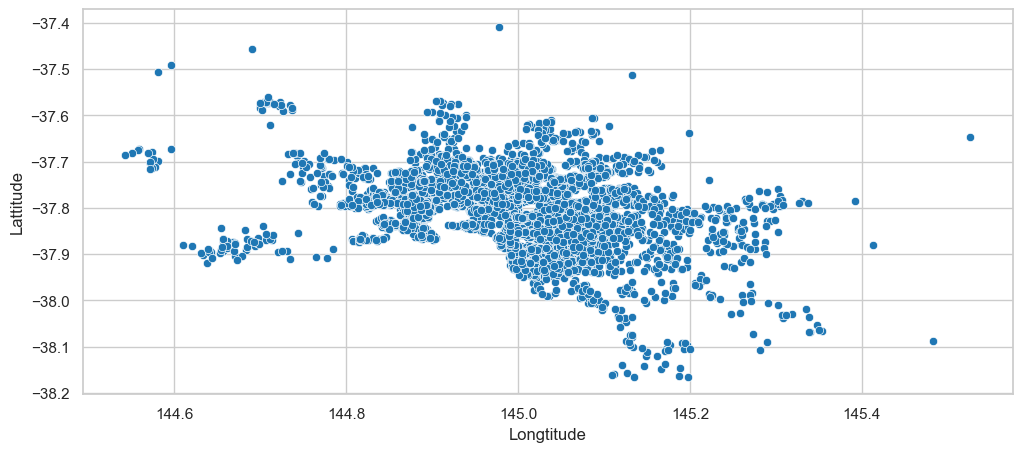

In [106]:
sns.scatterplot(
    data=train_set,
    x='Longtitude',
    y='Lattitude'
)

In [107]:
train_long_lat = train_set[['Longtitude', 'Lattitude']]
test_long_lat = test_set[['Longtitude', 'Lattitude']]

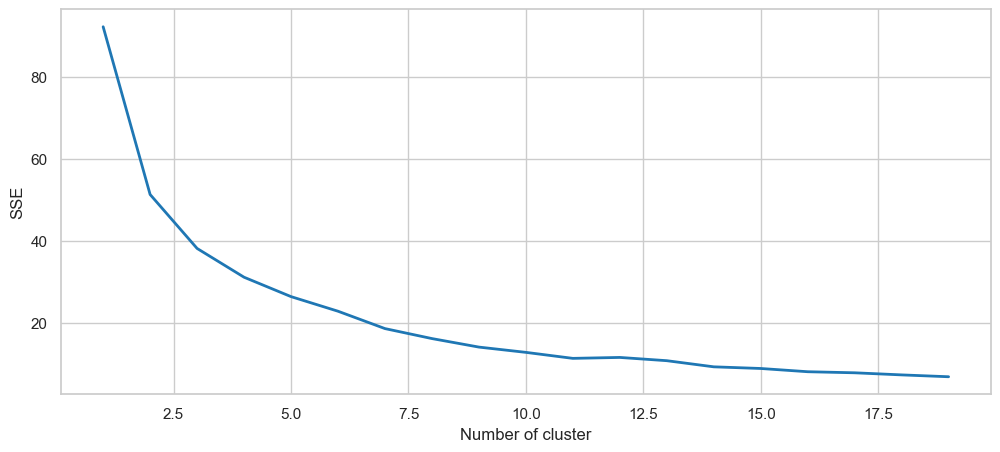

In [108]:
# Will watch which is the elbow

sse = {}
for k in range(1, 20):
    kmeans = KMeans(
        n_clusters=k, 
        max_iter=1000, 
        n_init='auto'
    ).fit(train_long_lat)
        
    # Squarred Sum of Errors
    sse[k] = kmeans.inertia_
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [184]:
divisor = 12
n_features = math.floor((train_set['YearBuilt'].nunique() / divisor))

print('Number of features: ', n_features)
k_means = KMeans(
    n_clusters=n_features, 
    n_init='auto',
    max_iter=1000
)

k_means.fit(train_long_lat)

Number of features:  9


KMeans(max_iter=1000, n_clusters=9, n_init='auto')

In [185]:
# With the same model trained we predict both groups for test & trian
labels_train = k_means.labels_
labels_test = k_means.predict(test_long_lat)

In [186]:
centroides = k_means.cluster_centers_
etiquetas = k_means.labels_

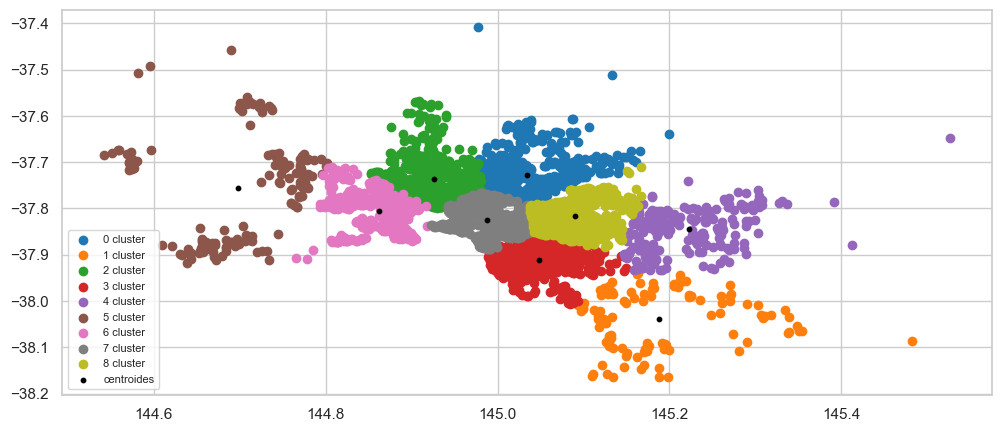

In [187]:
unique_labels = np.unique(labels_train)
 
for label in unique_labels:
    plt.scatter(
        train_long_lat.iloc[labels_train == label, 0], 
        train_long_lat.iloc[labels_train == label, 1], 
        label = f"{label} cluster",
    )

plt.scatter(
    centroides[:,0],
    centroides[:,1], 
    label='centroides', 
    color = 'k', 
    s=10
)

plt.legend(
    prop={'size': 8}
)
plt.show()

In [188]:
# Add this new feature into the dataframe
train_set_extended['location_group'] = labels_train
test_set_extended['location_group'] = labels_test

This location group might be very related to the council area, but we will try to use both and see which one works best.

## Suburb & Postal Codes

The postal codes might be an indication of which is the median income and distribution of the genders in the population in that area, which can therefore affect to the pricing.

In the **Australian portal**, we can see the distribution of this income nowadays (would not be able to extract the time series for the last hundred years). This could give us relevant data of which type of social status/system is in each of the postcodes.

In [114]:
import requests
from bs4 import BeautifulSoup as BeautifulSoup

AUSTRALIAN_CENSUS = 'https://www.abs.gov.au/census/find-census-data/quickstats/2021/POA'

In [189]:
unique_postcode = train_set_extended['Postcode'].unique()

response = requests.get(AUSTRALIAN_CENSUS + f'{3020}')

In [190]:
soup = BeautifulSoup(response.content, 'html.parser')

In [191]:
summary_container = soup.find_all('div', {'id': 'summary-container'})
summary_container

[<div class="summaryTables tw-flex-1 qs-border-gradient-top tw-p-4 tw-flex tw-flex-col tw-gap-2" id="summary-container"> <div class="tw-flex tw-gap-2 tw-content-start"> <img alt="" class="tw-self-start" height="50" src="/census/find-census-data/assets/people50x50-fb47894189c41cb03fc7c4b0f252c987.svg" width="50"/> <div class="tw-flex-1"> <table class="summaryTable qsPeople"> <tr class="strongRow"> <th scope="row">People</th> <td>44,372</td> </tr> <tr> <th scope="row">Male</th> <td>50.9%</td> </tr> <tr> <th scope="row">Female</th> <td>49.1%</td> </tr> <tr> <th scope="row">Median age</th> <td>37</td> </tr> </table> </div> </div> <div class="tw-flex tw-gap-2 tw-content-start"> <img alt="" class="tw-self-start" height="50" src="/census/find-census-data/assets/familes50x50-76dd3d03ad82b452874539b15e691e63.svg" width="50"/> <div class="tw-flex-1"> <table class="summaryTable qsFamilies"> <tr class="strongRow"> <th scope="row">Families</th> <td>11,142</td> </tr> <tr> <th>Average number of child

In [192]:
order_first_tr = [
    'people', 
    'male', 
    'female', 
    'median_age'
]

summary_container[0].find_all('table', {'class':'summaryTable'})[0].find_all('tr')

[<tr class="strongRow"> <th scope="row">People</th> <td>44,372</td> </tr>,
 <tr> <th scope="row">Male</th> <td>50.9%</td> </tr>,
 <tr> <th scope="row">Female</th> <td>49.1%</td> </tr>,
 <tr> <th scope="row">Median age</th> <td>37</td> </tr>]

In [193]:
order_second_tr = [
    'families', 
    '_', 
    'avg_children_families', 
    'avg_children_all'
]

summary_container[0].find_all('table', {'class':'summaryTable'})[1].find_all('tr')

[<tr class="strongRow"> <th scope="row">Families</th> <td>11,142</td> </tr>,
 <tr> <th>Average number of children per family</th> <td> <span class="sr-only">null</span></td> </tr>,
 <tr> <th class="tw-pl-8" scope="row">for families with children</th> <td>1.8</td> </tr>,
 <tr> <th class="tw-pl-8" scope="row">for all households (a)</th> <td>0.8</td> </tr>]

In [194]:
order_third_tr = [
    'private_dwellings', 
    'people_per_household', 
    'median_income', 
    'median_mortage_repayment', 
    'median_rent', 
    'motor_vehicles_per_dwelling'
]

summary_container[0].find_all('table', {'class':'summaryTable'})[2].find_all('tr')

[<tr class="strongRow"> <th scope="row">All private dwellings</th> <td>17,617</td> </tr>,
 <tr> <th scope="row">Average number of people per household</th> <td>2.7</td> </tr>,
 <tr> <th scope="row" title="Median incomes have been estimated for each income range using data from the Survey of Income and Housing.">Median weekly household income</th> <td>$1,428</td> </tr>,
 <tr> <th scope="row">Median monthly mortgage repayments</th> <td>$1,733</td> </tr>,
 <tr> <th scope="row">Median weekly rent (b)</th> <td>$340</td> </tr>,
 <tr> <th scope="row">Average number of motor vehicles per dwelling</th> <td>1.7</td> </tr>]

In [195]:
orders = {
    0: order_first_tr,
    1: order_second_tr,
    2: order_third_tr
}

In [196]:
def get_init_australian_df():
    australian_df = pd.DataFrame(columns=[
        *order_first_tr, 
        order_second_tr[0], 
        *order_second_tr[2:],
        *order_third_tr
    ], index=unique_postcode)
    
    return australian_df

In [197]:
def get_summary_tables_postcode(postcode: int):
    response = requests.get(
        AUSTRALIAN_CENSUS + f'{postcode}'
    )
    
    soup = BeautifulSoup(response.content, 'html.parser')
    
    summary_container = soup.find_all('div', {
        'id': 'summary-container'
    })[0]
    
    summary_tables = summary_container.find_all('table', {
        'class':'summaryTable'
    })
    
    return summary_tables

In [198]:
def get_australian_data(save: bool = True):
    # TODO: Check if firs the file is found in file system and has all the postcodes data
    # If not, execute the extraction
    australian_df = get_init_australian_df()
    
    for idx_postcode, postcode in enumerate(unique_postcode):    
        summary_tables = get_summary_tables_postcode(postcode)

        # 3 summary tables
        for idx, summ_table in enumerate(summary_tables):
            # Dictionary of the order of the data
            order = orders[idx]

            table_rows = summ_table.find_all('tr')

            for idx, row in enumerate(table_rows):
                # If is an empty string (no data needed for that)
                if order[idx] == '_':
                    continue

                value = row.find('td').text
                value = value.replace(',', '')
                value = value.replace('%', '')
                value = value.replace('$', '')
                value = value.replace('\xa0null', '')
                value = float(value) if value else .0

                australian_df.loc[postcode, order[idx]] = value
    
    if save:
        australian_df.to_csv('australian_census.csv', index=True, header=True)
        
    return australian_df

In [170]:
australian_df = get_australian_data() if not os.path.exists('australian_census.csv') else pd.read_csv('australian_census.csv', index_col=0)
australian_df = australian_df.reset_index().rename(columns={'index':'Postcode'})
australian_df.head(3)

,Postcode,people,male,female,median_age,families,avg_children_families,avg_children_all,private_dwellings,people_per_household,median_income,median_mortage_repayment,median_rent,motor_vehicles_per_dwelling
0,3040,26722.0,48.6,51.4,39.0,6972.0,1.8,0.7,12182.0,2.4,2199.0,2383.0,385.0,1.7
1,3070,25276.0,47.3,52.7,37.0,6257.0,1.7,0.6,11625.0,2.3,2287.0,2400.0,475.0,1.4
2,3104,21302.0,49.1,50.9,42.0,5931.0,1.8,1.0,7942.0,2.9,2346.0,3078.0,554.0,2.0


In [212]:
train_set_extended_australian = pd.merge(train_set, australian_df, left_on='Postcode', right_on='Postcode', how='inner')
train_set_extended_australian

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Price_log,people,male,female,median_age,families,avg_children_families,avg_children_all,private_dwellings,people_per_household,median_income,median_mortage_repayment,median_rent,motor_vehicles_per_dwelling
0,South Melbourne,352 Moray St,4,h,2260000.0,PI,Marshall,2016-07-05,2.1,3205.0,5.0,3.0,0.0,190.0,232.000000,1856.0,Port Phillip,-37.83770,144.96530,Southern Metropolitan,5943.0,14.630875,11548.0,49.1,50.9,39.0,2853.0,1.6,0.3,7265.0,1.9,2101.0,2200.0,421.0,1.1
1,South Melbourne,315 Moray St,4,h,2180000.0,S,Marshall,2016-10-12,2.1,3205.0,4.0,3.0,1.0,200.0,153.000000,1860.0,Port Phillip,-37.83600,144.96500,Southern Metropolitan,5943.0,14.594835,11548.0,49.1,50.9,39.0,2853.0,1.6,0.3,7265.0,1.9,2101.0,2200.0,421.0,1.1
2,South Melbourne,52 Eastern Rd,3,h,2525000.0,S,Marshall,2016-11-27,2.1,3205.0,3.0,2.0,1.0,234.0,-50.868776,1863.0,Port Phillip,-37.83550,144.96630,Southern Metropolitan,5943.0,14.741752,11548.0,49.1,50.9,39.0,2853.0,1.6,0.3,7265.0,1.9,2101.0,2200.0,421.0,1.1
3,South Melbourne,248 Montague St,3,h,1650000.0,VB,Marshall,2016-09-17,2.1,3205.0,3.0,2.0,0.0,204.0,195.000000,1890.0,Port Phillip,-37.83570,144.95310,Southern Metropolitan,5943.0,14.316286,11548.0,49.1,50.9,39.0,2853.0,1.6,0.3,7265.0,1.9,2101.0,2200.0,421.0,1.1
4,South Melbourne,247 York St,3,h,1250000.0,S,Greg,2016-08-10,2.1,3205.0,3.0,2.0,0.0,224.0,113.000000,1890.0,Port Phillip,-37.83290,144.95290,Southern Metropolitan,5943.0,14.038654,11548.0,49.1,50.9,39.0,2853.0,1.6,0.3,7265.0,1.9,2101.0,2200.0,421.0,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5185,Williams Landing,89 Sayers Rd,4,h,510000.0,S,Ray,2017-01-07,17.6,3027.0,4.0,2.0,2.0,443.0,443.000000,1950.0,Wyndham,-37.85430,144.74437,Western Metropolitan,1999.0,13.142166,9448.0,52.3,47.7,31.0,2458.0,1.8,1.0,3186.0,3.2,2582.0,2167.0,420.0,1.8
5186,Docklands,1508/50 Lorimer St,2,u,800000.0,VB,RT,2016-06-27,1.9,3008.0,2.0,2.0,2.0,0.0,-103.199861,1900.0,Melbourne,-37.82490,144.94760,Southern Metropolitan,4707.0,13.592367,15495.0,51.9,48.1,32.0,3899.0,1.3,0.2,10827.0,1.8,1957.0,2000.0,411.0,0.8
5187,Diggers Rest,15 Eureka Rd,3,h,435000.0,S,YPA,2017-05-27,27.7,3427.0,3.0,1.0,2.0,608.0,-41.792478,2000.0,Melton,-37.62040,144.71138,Western Metropolitan,1184.0,12.983101,5669.0,50.2,49.8,33.0,1608.0,1.7,0.8,2300.0,2.6,1991.0,1800.0,397.0,2.0
5188,Monbulk,21 David St,4,h,720000.0,SP,Fletchers,2017-08-26,34.1,3793.0,4.0,2.0,2.0,1611.0,19.632251,1970.0,Knox,-37.87931,145.41288,Eastern Victoria,1424.0,13.487006,3651.0,50.1,49.9,41.0,1026.0,1.9,0.9,1422.0,2.7,1722.0,1915.0,369.0,2.2


In [213]:
# We will compute a classification of rich areas, which will be the amount of people * median income per household / people per household
train_set_extended_australian['median_rent'] = train_set_extended_australian['people'] * \
    train_set_extended_australian['median_income'] / \
    train_set_extended_australian['people_per_household']

train_set_extended_australian.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Price_log,people,male,female,median_age,families,avg_children_families,avg_children_all,private_dwellings,people_per_household,median_income,median_mortage_repayment,median_rent,motor_vehicles_per_dwelling
0,South Melbourne,352 Moray St,4,h,2260000.0,PI,Marshall,2016-07-05,2.1,3205.0,5.0,3.0,0.0,190.0,232.000000,1856.0,Port Phillip,-37.8377,144.9653,Southern Metropolitan,5943.0,14.630875,11548.0,49.1,50.9,39.0,2853.0,1.6,0.3,7265.0,1.9,2101.0,2200.0,1.276966e+07,1.1
1,South Melbourne,315 Moray St,4,h,2180000.0,S,Marshall,2016-10-12,2.1,3205.0,4.0,3.0,1.0,200.0,153.000000,1860.0,Port Phillip,-37.8360,144.9650,Southern Metropolitan,5943.0,14.594835,11548.0,49.1,50.9,39.0,2853.0,1.6,0.3,7265.0,1.9,2101.0,2200.0,1.276966e+07,1.1
2,South Melbourne,52 Eastern Rd,3,h,2525000.0,S,Marshall,2016-11-27,2.1,3205.0,3.0,2.0,1.0,234.0,-50.868776,1863.0,Port Phillip,-37.8355,144.9663,Southern Metropolitan,5943.0,14.741752,11548.0,49.1,50.9,39.0,2853.0,1.6,0.3,7265.0,1.9,2101.0,2200.0,1.276966e+07,1.1


/tmp/ipykernel_2354179/1982666728.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()['median_rent']


<AxesSubplot: >

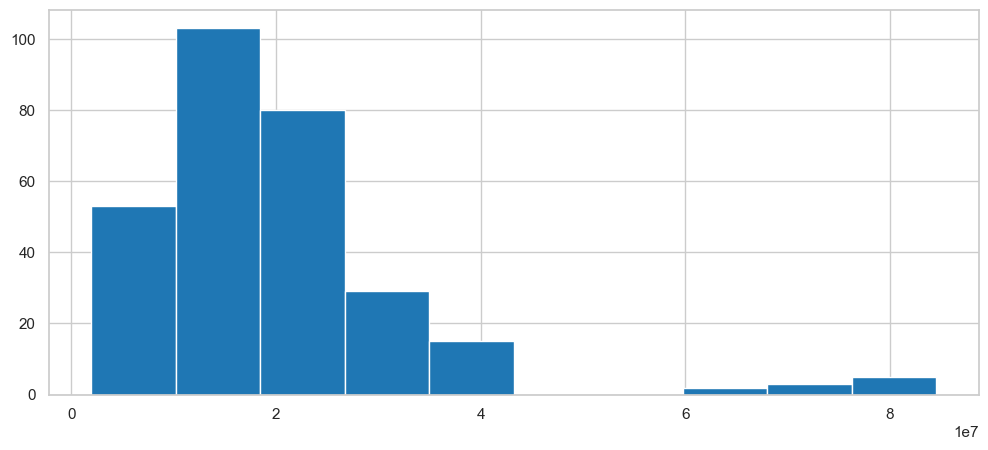

In [221]:
distribution_rent = train_set_extended_australian\
    .groupby(['Suburb'])\
    .mean()['median_rent']

distribution_rent\
    .hist()

In [224]:
# Will create a new categorical feature, of very rich (>6). Rich if 75% percentile, and else normal.
distribution_rent.describe()

count    2.900000e+02
mean     2.008102e+07
std      1.372836e+07
min      1.904990e+06
25%      1.110632e+07
50%      1.741460e+07
75%      2.467717e+07
max      8.455050e+07
Name: median_rent, dtype: float64

In [231]:
# 2 = very rich, 1 = rich, 0 = normal
very_rich = distribution_rent[distribution_rent > 6e7]

rich = distribution_rent[
    (distribution_rent > distribution_rent.quantile(.75)) & 
    (distribution_rent < 6e7)
]

normal = distribution_rent[distribution_rent < distribution_rent.quantile(.75)]

In [238]:
very_rich_suburbs = very_rich.index.values.tolist()
normal_suburbs = normal.index.values.tolist()
rich_suburbs = rich.index.values.tolist()

In [241]:
# And create the new feature based on that
train_set_extended.loc[
    train_set_extended['Suburb'].isin(very_rich_suburbs),
    'suburb_wealth'
] = 2

train_set_extended.loc[
    train_set_extended['Suburb'].isin(rich_suburbs),
    'suburb_wealth'
] = 2

train_set_extended.loc[
    train_set_extended['Suburb'].isin(normal_suburbs),
    'suburb_wealth'
] = 1

In [242]:
postcode_features = ['suburb_wealth']

In [ ]:
# TODO: PCA For this variables
# TODO: Group the postcodes in suburbs for example or in groups

## Ratios

We are going to create ratios that could be interesting features to the model.
- landsize/building_area
- bedrooms/building_area
- rooms/building_area
- car/building_area
- 

## Logs

We will create also some logarithms of the columns:

In [367]:
train_set_extended['Distance_log'] = np.log(train_set_extended['Distance'])
train_set_extended['Landsize_log'] = np.log(train_set_extended['Landsize'])
train_set_extended['BuildingArea_log'] = np.log(train_set_extended['BuildingArea'])
train_set_extended['Propertycount_log'] = np.log(train_set_extended['Propertycount'])

test_set_extended['Distance_log'] = np.log(test_set_extended['Distance'])
test_set_extended['Landsize_log'] = np.log(test_set_extended['Landsize'])
test_set_extended['BuildingArea_log'] = np.log(test_set_extended['BuildingArea'])
test_set_extended['Propertycount_log'] = np.log(test_set_extended['Propertycount'])

/home/nil/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nil/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nil/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nil/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nil/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [357]:
log_features = ['Distance_log', 'BuildingArea_log', 'Landsize_log', 'Propertycount_log']

## Square

Same but making the exponential of the values.


In [385]:
train_set_extended['Distance_sqr'] = train_set_extended['Distance'] * train_set_extended['Distance']
train_set_extended['Landsize_sqr'] = train_set_extended['Landsize'] * train_set_extended['Landsize'] 
train_set_extended['BuildingArea_sqr'] = train_set_extended['BuildingArea'] * train_set_extended['BuildingArea']
train_set_extended['Propertycount_sqr'] = train_set_extended['Propertycount'] * train_set_extended['Propertycount']

test_set_extended['Distance_sqr'] = test_set_extended['Distance'] * test_set_extended['Distance']
test_set_extended['Landsize_sqr'] = test_set_extended['Landsize'] * test_set_extended['Landsize']
test_set_extended['BuildingArea_sqr'] = test_set_extended['BuildingArea'] * test_set_extended['BuildingArea']
test_set_extended['Propertycount_sqr'] = test_set_extended['Propertycount'] * test_set_extended['Propertycount']

In [386]:
sqr_features = ['Distance_sqr', 'Landsize_sqr', 'BuildingArea_sqr', 'Propertycount_sqr']

## Model Creation

In some we do cross-validation, and in others train/val split.

## K-Neighbor Regressor

#### Council Area Features

In [387]:
n_neighbors = 2
X = train_set_extended[[*council_features, 'YearBuilt', 'Propertycount', 'BuildingArea', 'Bedroom2']]
X.fillna(0.0, inplace=True)
Y = train_set['Price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

model = KNeighborsRegressor(n_neighbors)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

print(mean_squared_error(Y_test, y_pred, squared=False))
r2_score(Y_test, y_pred)

376852.6962087676


0.4955261903531314

#### Location Group

In [244]:
n_neighbors = 2
X = train_set_extended[['location_group', 'YearBuilt', 'Propertycount', 'BuildingArea', 'Bedroom2']]
X.fillna(0.0, inplace=True)
Y = train_set['Price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

model = KNeighborsRegressor(n_neighbors)
model.fit(X_train, Y_train)

KNeighborsRegressor(n_neighbors=2)

In [245]:
y_pred = model.predict(X_test)

print(mean_squared_error(Y_test, y_pred, squared=False))
r2_score(Y_test, y_pred)

372823.7408029318


0.5062552507958546

TODO: With KNN might need min-max scaling

## Linear Regression

## Decision Trees

In [122]:
train_set_extended.head(3)

,Suburb,Rooms,Price,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Regionname,Propertycount,Price_log,year_sold,month_sold,quarter_sold,day_of_week_sold,day_of_month_sold,day_of_year_sold,week_of_month_sold,week_of_year_sold,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,winter,spring,summer,fall,diff_built_sold,Resold,CouncilArea_Bayside,CouncilArea_Boroondara,CouncilArea_Brimbank,CouncilArea_Cardinia,CouncilArea_Casey,CouncilArea_Darebin,CouncilArea_Frankston,CouncilArea_Glen Eira,CouncilArea_Greater Dandenong,CouncilArea_Hobsons Bay,CouncilArea_Hume,CouncilArea_Kingston,CouncilArea_Knox,CouncilArea_Macedon Ranges,CouncilArea_Manningham,CouncilArea_Maribyrnong,CouncilArea_Maroondah,CouncilArea_Melbourne,CouncilArea_Melton,CouncilArea_Monash,CouncilArea_Moonee Valley,CouncilArea_Moreland,CouncilArea_Nillumbik,CouncilArea_Port Phillip,CouncilArea_Stonnington,CouncilArea_Unavailable,CouncilArea_Whitehorse,CouncilArea_Whittlesea,CouncilArea_Wyndham,CouncilArea_Yarra,CouncilArea_Yarra Ranges,Method_S,Method_SA,Method_SP,Method_VB,Type_t,Type_u,location_group
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4823,South Melbourne,4,2260000.0,Marshall,2016-07-05,2.1,3205.0,5.0,3.0,0.0,190.0,232.000000,1856.0,-37.8377,144.9653,Southern Metropolitan,5943.0,14.630875,2016,7,3,2,5,187,1,27,0,0,0,0,0,0,0,1,1,0,1,160.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3285,South Melbourne,4,2180000.0,Marshall,2016-10-12,2.1,3205.0,4.0,3.0,1.0,200.0,153.000000,1860.0,-37.8360,144.9650,Southern Metropolitan,5943.0,14.594835,2016,10,4,3,12,286,2,41,0,0,0,0,0,0,0,1,1,1,0,156.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
68,South Melbourne,3,2525000.0,Marshall,2016-11-27,2.1,3205.0,3.0,2.0,1.0,234.0,-50.868776,1863.0,-37.8355,144.9663,Southern Metropolitan,5943.0,14.741752,2016,11,4,7,27,332,4,47,1,0,0,0,0,0,0,1,1,1,0,153.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [388]:
def get_all_features():
    all_features = [
        'location_group', 
        'YearBuilt', 
        'Propertycount', 
        'Rooms',
        'Landsize', 
        'BuildingArea',
        'Distance',
        'Bedroom2', 
        'Bathroom',
        'Car', 
    ]

    all_features = all_features + postcode_features   # not providing good results, as we do not have historical info
    all_features = all_features + seller_features
    all_features = all_features + log_features
    all_features = all_features + sqr_features
    all_features = all_features + method_features[:-1]  # multicollinearity: we exclude one variable
    all_features = all_features + type_features[:-1]
    all_features = all_features + council_features[:-1]  
    all_features = all_features + date_features
    
    return all_features

In [389]:
all_features = get_all_features()
all_features

['location_group',
 'YearBuilt',
 'Propertycount',
 'Rooms',
 'Landsize',
 'BuildingArea',
 'Distance',
 'Bedroom2',
 'Bathroom',
 'Car',
 'suburb_wealth',
 'seller_class',
 'Distance_log',
 'BuildingArea_log',
 'Landsize_log',
 'Propertycount_log',
 'Distance_sqr',
 'Landsize_sqr',
 'BuildingArea_sqr',
 'Propertycount_sqr',
 'Method_S',
 'Method_SA',
 'Method_SP',
 'Type_t',
 'CouncilArea_Bayside',
 'CouncilArea_Boroondara',
 'CouncilArea_Brimbank',
 'CouncilArea_Cardinia',
 'CouncilArea_Casey',
 'CouncilArea_Darebin',
 'CouncilArea_Frankston',
 'CouncilArea_Glen Eira',
 'CouncilArea_Greater Dandenong',
 'CouncilArea_Hobsons Bay',
 'CouncilArea_Hume',
 'CouncilArea_Kingston',
 'CouncilArea_Knox',
 'CouncilArea_Macedon Ranges',
 'CouncilArea_Manningham',
 'CouncilArea_Maribyrnong',
 'CouncilArea_Maroondah',
 'CouncilArea_Melbourne',
 'CouncilArea_Melton',
 'CouncilArea_Monash',
 'CouncilArea_Moonee Valley',
 'CouncilArea_Moreland',
 'CouncilArea_Nillumbik',
 'CouncilArea_Port Phillip',

In [390]:
X = train_set_extended.loc[:, all_features]
X['YearBuilt'].fillna(X['YearBuilt'].mean(), inplace=True)
X['diff_built_sold'].fillna(X['diff_built_sold'].mean(), inplace=True)

# TODO: With logs we had nan
X.fillna(0.0, inplace=True)

print(X.isnull().values.any()) # TODO: Solve the nulls of yearbuilt


Y = train_set['Price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

False


### Feature Importance

Check first which is the importance of the features in that model, and then simplify the model with that selection.

This will also help avoid overfitting.

For doing this selection, we will do a quick implementation with CatBoost to get an idea of which features could be interesting.

In [391]:
# Combine the inputs to allow catboost create the features
cb_train = cb.Pool(X_train, Y_train)
cb_test = cb.Pool(X_test, Y_test)

In [ ]:
grid = {
    # 'iterations': [50, 100, 150, 200, 250],
    'learning_rate': [0.01, 0.03, 0.1],
    'depth': [2, 4, 6, 8, 10, 12],
    'l2_leaf_reg': [0.2, 0.5, 1, 3],
    'n_estimators': [300, 500, 1000, 2000],
}

cat_model = CatBoostRegressor(
    random_seed=1,
    loss_function='RMSE',
    logging_level='Silent'
)

# Train the model with grid search, and select the best one
best_cat_hp = cat_model.randomized_search(
    grid, 
    cb_train, 
    verbose=0,
)

In [ ]:
pred_cat = cat_model.predict(X_test)
print(mean_squared_error(Y_test, pred_cat, squared=False))
print(r2_score(Y_test, pred_cat))

In [ ]:
# Can see also which are the importance of the features in the dataset
feature_importance = cat_model.feature_importances_.argsort().astype(int)

f, ax = plt.subplots(figsize = (10,15))

sns.barplot(
    y=[cat_model.feature_names_[idx] for idx in feature_importance[::-1]],
    x=[cat_model.feature_importances_[idx] for idx in feature_importance[::-1]],
    color='turquoise',
    ax=ax
)

sns.despine(left = True, bottom = True)

In [373]:
# TODO: make log of property count and see how it works
# TODO: PCA of the variables so we reduce variance and overfitting

TODO: https://towardsdatascience.com/shap-for-categorical-features-with-catboost-8315e14dac1

TODO: https://towardsdatascience.com/understand-the-working-of-shap-based-on-shapley-values-used-in-xai-in-the-most-simple-way-d61e4947aa4e

### Training

In [ ]:
space = {
    'eta': hp.uniform('eta', 0.01, 0.1),
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
    'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': hp.uniform('n_estimators', 200, 1000),
    'seed': 0
}

In [ ]:
def select_idx_features_threshold(threshold) -> typing.List[int]:
    top_features_idx = []
    for idx, value in enumerate(cat_model.feature_importances_):
        if value > threshold:
            top_features_idx.append(idx)
    
    return top_features_idx

def select_features_threshold(threshold: float = 3.0):
    top_features_idx = select_idx_features_threshold(threshold)
        
    top_features = [cat_model.feature_names_[idx] for idx in top_features_idx]
    
    return top_features

top_features = select_features_threshold(.25)
top_features

In [ ]:
X = train_set_extended[top_features]
Y = train_set['Price']

X.replace([np.inf, -np.inf], 0.0, inplace=True)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [ ]:
def objective_function(
    hp_space: typing.Dict[str, typing.Any],
    
):
    # Define the groups of training and testing
    eval_set = [(X_test, Y_test)]
    
    hp_params = {
        "eta": hp_space.get('eta', 0.05), 
        "gamma": int(hp_space.get('gamma', 10)),
        "subsample": hp_space.get('subsample', 0.7), 
        "reg_lambda": hp_space.get('reg_alpha', 0.3),
        "max_depth": int(hp_space.get('max_depth', 3)),
        "reg_alpha": int(hp_space.get('reg_alpha', 60)),
        "n_estimators": int(hp_space.get('n_estimators', 1000)),
        "min_child_weight": int(hp_space.get('min_child_weight', 6)),
        "colsample_bytree": hp_space.get('colsample_bytree', 0.8),
        "random_state": 0
    }
    
    # Define model hyperparameters
    model = xgb.XGBRegressor(
        **hp_params,
        verbosity=0,
        silent=True
    )
    
    # Train the model
    model.fit(
        X_train,
        Y_train,
        # Evaluation and preventing overfit
        eval_set=eval_set,
        eval_metric='rmse',
        early_stopping_rounds=20,
        verbose=False
    )
    
    y_pred = model.predict(X_test)
    
    error = mean_squared_error(Y_test, y_pred, squared=False)
        
    # For the HP package to recognize and evolve
    return {'loss': round(error, 2), 'status': STATUS_OK}

In [ ]:
trials = Trials()

hp_best = fmin(
    fn = objective_function,
    space = space,
    algo = tpe.suggest,
    max_evals = 10,
    trials = trials
)

In [ ]:
hp_best

In [ ]:
hp_best = {
    "eta": hp_best.get('eta', 0.05), 
    "gamma": int(hp_best.get('gamma', 10)),
    "subsample": hp_best.get('subsample', 0.7), 
    "reg_lambda": hp_best.get('reg_alpha', 0.3),
    "max_depth": int(hp_best.get('max_depth', 3)),
    "reg_alpha": int(hp_best.get('reg_alpha', 60)),
    "n_estimators": int(hp_best.get('n_estimators', 1000)),
    "min_child_weight": int(hp_best.get('min_child_weight', 6)),
    "colsample_bytree": hp_best.get('colsample_bytree', 0.8),
    "random_state": 0
}

xgboost_model = xgb.XGBRegressor(**hp_best)

xgboost_model.fit(X_train, Y_train)
y_test_pred = xgboost_model.predict(X_train)

print(
    'Mean Squarred Error in Training: ', 
    mean_squared_error(
        Y_train, 
        y_test_pred, 
        squared=False
    )
)

y_pred = xgboost_model.predict(X_test)

mean_squared_error(
    Y_test, 
    y_pred, 
    squared=False
)

print('Mean Squarred Error in Testing:  ', mean_squared_error(Y_test, y_pred, squared=False))
print('R-Squarred in Testing:           ', r2_score(Y_test, y_pred))

## CatBoost

## LightGBM

## TODO's

- Each model for division
- Data with same ranges as test (and same parameters for conversion/normalization)
- Handle NaN yearbuilt
- Check time lapse between house built and solt as yearbuilt feature
- Apply catboost